# Project Stage - II (Data Modeling and Hypothesis Testing)

## Goals
The goal of Stage II is to develop formal hypothesis for the intuitions we had in stage I and utilize statistical modeling to prove/ disprove them.

## Tasks:

#### Task 2

##### Member Task
* Fit a distribution to the number of COVID-19 **new** cases of a state of your choosing.
    + Graphically plot the distribution and describe the distribution statistics. If using discrete values, calculate the Probability Mass Function for the individual values or range (if using histogram) and plot that.
    + Describe the type of distribution (modality) and its statistics (moments of a distribution - center, variance, skewness, kurtosis) in the report and the notebook.
    + Compare the distribution and its statistics to 5 other states of your choosing.
<br/><br/>
* Model a poission distribution of COVID-19 cases and deaths of a state and compare to other 5 states. For example, number of new cases and deaths per 100,000 population. Hint - the parameter for a poission's distribution will be its mean value. Then for the minimum and maximum range of covid cases you are calculating probability mass function to observe the probability at different points.

* Model poission distributions for North Carolina counties COVID-19 in cases and deaths. For example, number of new cases and deaths per 100,000 populations.

* Perform corelation between Enrichment data valiables and COVID-19 cases to observe any patterns.
    + You can compare either within your chosen specific state or among different states with the different enrichment variables. Within the state you can compare the county based covid data to enrichment data for correlation. Between states you would need to aggregate to state level data and then perform correlation. Both covid and enrichment data will need to be normalized for population. For number of covid cases you can use a measure of center value (median or mean) to compare the number of cases.
<br/><br/>
* Formulate hypothesis between Enrichment data and number of cases to be compared against states. Choose 3 different variables to compare against.
    + For example: Does higher employment data lead to higher covid case numbers or more rapid increase in covid cases.

<br/><hr/>

# Import modules

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from math import inf
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import Markdown as md
from IPython.display import Image
from scipy.stats import poisson

# Import Super Dataset

In [2]:
super_dataset = pd.read_csv("../../../../data/stage_I/superDataset.csv")
super_dataset.head()

,countyFIPS,County Name,State,StateFIPS,population,2020-01-22_cases,2020-01-22_deaths,2020-01-23_cases,2020-01-23_deaths,2020-01-24_cases,...,2021-03-13_cases,2021-03-13_deaths,2021-03-14_cases,2021-03-14_deaths,2021-03-15_cases,2021-03-15_deaths,2021-03-16_cases,2021-03-16_deaths,2021-03-17_cases,2021-03-17_deaths
0,0,Statewide Unallocated,AL,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1001,Autauga County,AL,1,55869,0,0,0,0,0,...,6416,95,6426,95,6471,95,6474,95,6483,96
2,1003,Baldwin County,AL,1,223234,0,0,0,0,0,...,20091,294,20103,294,20210,294,20227,294,20263,295
3,1005,Barbour County,AL,1,24686,0,0,0,0,0,...,2181,53,2184,53,2195,53,2198,53,2199,54
4,1007,Bibb County,AL,1,22394,0,0,0,0,0,...,2479,60,2481,60,2499,60,2508,60,2512,60


# Select State

In [3]:
my_state = "MA"
state_data = super_dataset[super_dataset.State == my_state]
state_cases = state_data.drop([i for i in state_data.columns if "deaths" in i], axis=1)
state_cases.columns = [i.replace("_cases", "") for i in state_cases.columns]

In [4]:
md("### Find total 'new' cases across {0} for each day".format(my_state))

### Find total 'new' cases across MA for each day

In [5]:
# Slice dataframe, take columns from index 5 to the end (they are the date columns)
# Find the sum (this gives the total number of cases per day)
total_state_cases = pd.DataFrame(state_cases.iloc[:, 5:].sum(), columns=['total'])
# Find difference between rows to get the number of new cases per day
temp = total_state_cases.diff()
# Replace first row of difference dataframe with first row of initial dataframe, to preserve the first values
temp.iloc[0] = total_state_cases.iloc[0]
total_state_cases = temp
del temp
total_state_cases['date'] = total_state_cases.index
total_state_cases[["year", "week", "day"]] = pd.DataFrame(total_state_cases.date.apply(lambda x: datetime.strptime(x, "%Y-%m-%d").isocalendar()).to_list(), index=total_state_cases.index)
total_state_cases.drop(['date', 'day'], axis=1, inplace=True)
total_state_cases = total_state_cases.astype('int')

In [6]:
total_state_cases

,total,year,week
2020-01-22,0,2020,4
2020-01-23,0,2020,4
2020-01-24,0,2020,4
2020-01-25,0,2020,4
2020-01-26,0,2020,4
...,...,...,...
2021-03-13,0,2021,10
2021-03-14,2995,2021,10
2021-03-15,1105,2021,11
2021-03-16,1022,2021,11


<div class="alert-success">
    <h2 style="text-align:center;"><br/><strong>Plot the distribution</strong><br/><br/></h2>
</div>

array([[<AxesSubplot:title={'center':'total'}>]], dtype=object)

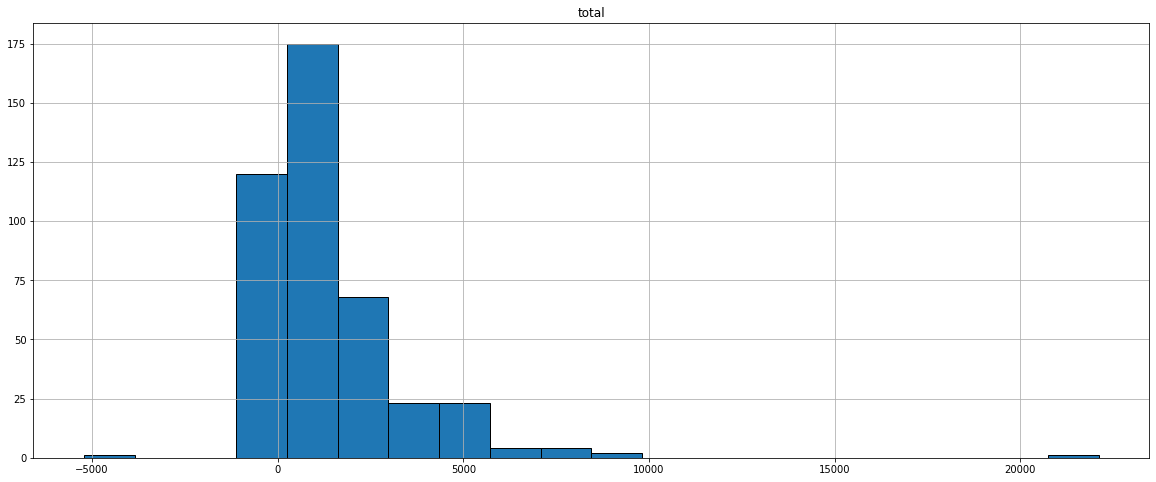

In [7]:
total_state_cases.hist(column='total', bins=20, ec='black', figsize=(20,8))

## Filter outliers and false observations

From the above histogram, we can observe that we have some negative values in the data which is a false value as the number of new cases cannot be negative. Also, we can see some days with more than 20000 new cases. While this is not a false value, we can still assume from the huge gap between this value and the next largest value that this is an outlier.

Lets remove the negative and highest value and observe the distribution.

array([[<AxesSubplot:title={'center':'total'}>]], dtype=object)

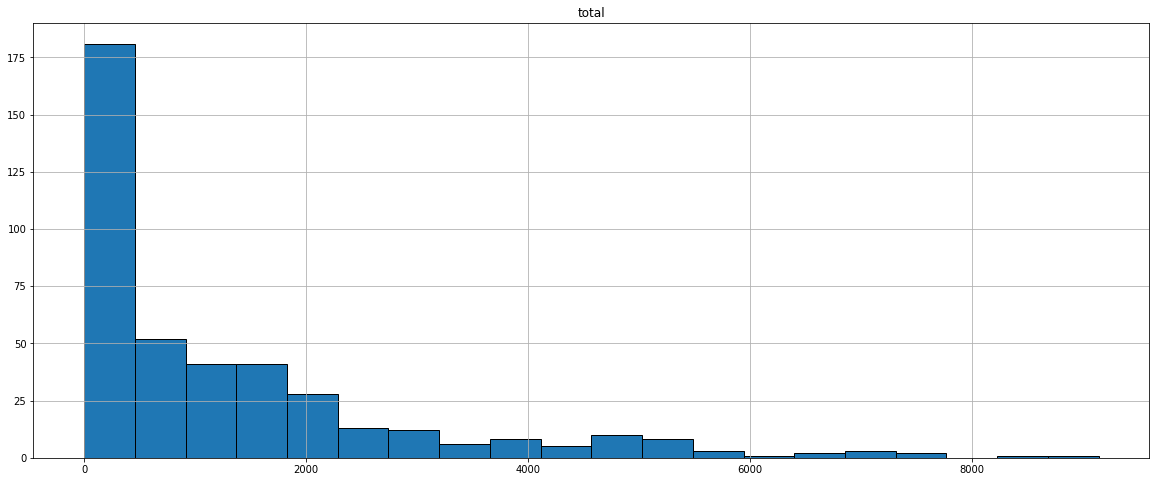

In [8]:
# Remove any row that have negative values
filtered = total_state_cases[total_state_cases.total >= 0]
# Remove the maximum value
filtered = filtered[filtered.total != filtered.total.max()]
filtered.hist(column='total', bins=20, ec='black', figsize=(20,8))

In [9]:
from math import ceil, floor

min_val, max_val = filtered.total.min(), filtered.total.max()
div_min, div_max = 10**int(len(str(int(min_val)))-2), 10**int(len(str(int(max_val)))-2)
min_round, max_round = floor(floor(min_val/div_min)*div_min), ceil(max_val/div_max)*div_max

In [10]:
bins = 20
factor = int(max_round/bins)
dataset = filtered
freq = {}
for i in range(bins):
    low, high = i*factor, (i+1)*factor
    times = dataset[(dataset.total >= low) & (dataset.total < high)].total.count()
    freq.update({"{0}-{1}".format(int(low/100), int(high/100)): times})

In [11]:
gap = []
probs = []
total = sum(freq.values())
for k,v in freq.items():
    prob = round(v/total, 3)
    gap.append(k)
    probs.append(prob)

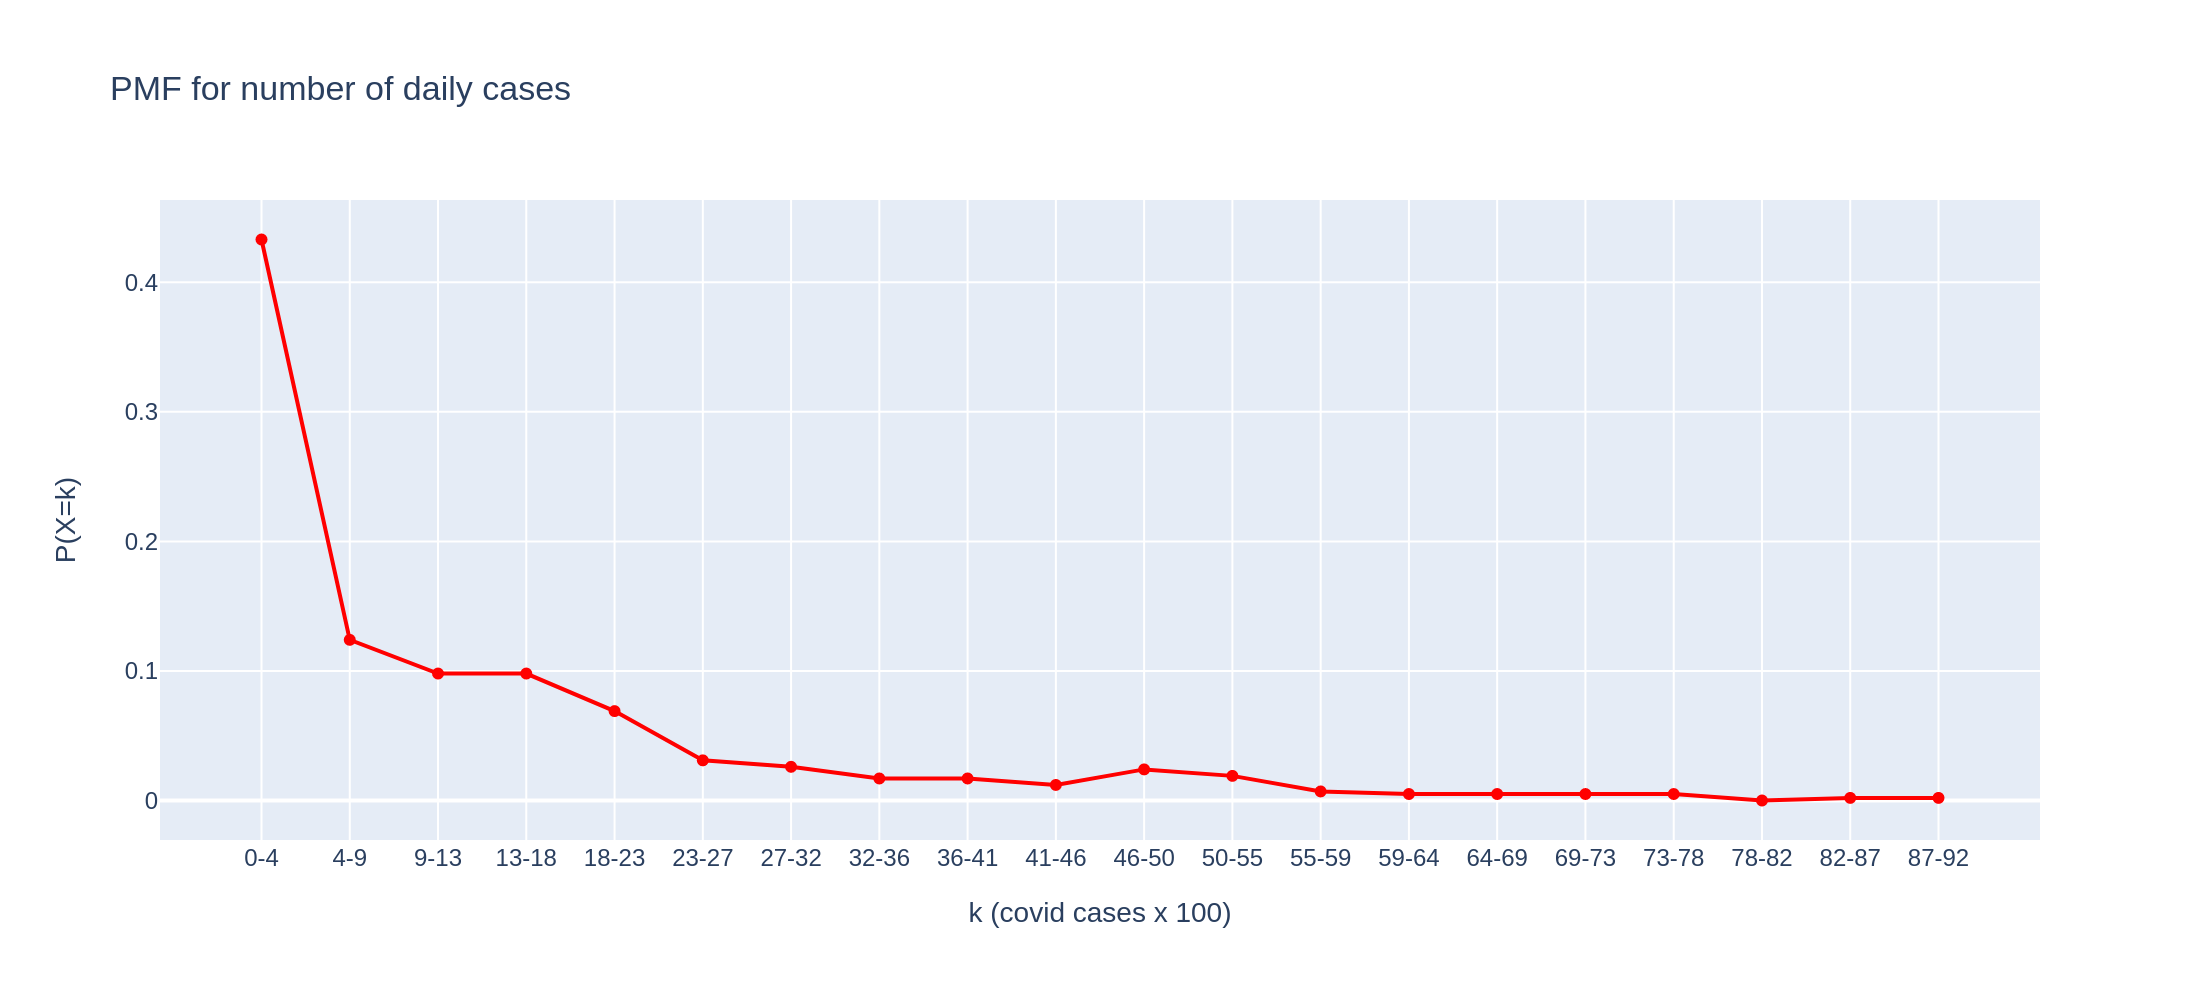

In [12]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=gap, y=probs, mode='lines+markers', marker_color='red'))
# fig = px.scatter(x=temp.range, y=temp.probability)
fig.update_layout(
    title="PMF for number of daily cases",
    xaxis_title="k (covid cases x 100)",
    yaxis_title="P(X=k)",
    height=500,
)
# fig.show()
img_bytes = fig.to_image(format="png", width=1100, height=500, scale=2)
Image(img_bytes)

Probability Mass Function or PMF gives us the probability of a given outcome.

In our case, the random variable X represents the number of covid cases in a particular day. Since the value of random variable can go from 0 all the way up to 56000, it will not be reasonable to plot that. Also, given the number of total days in our case, we might never see certain values of x and the probability of getting that particular value will be 0.

To model this in a better way, we can take a range of values as possible outcome of x. Here, I have divided the values into 20 equal sized groups. Then I calculated the frequency of days where the number of covid cases is within that particular range. Each frequency divided by the total number of observations (total number of days in our case) returns the probability for each group.

array([[<AxesSubplot:title={'center':'total'}>]], dtype=object)

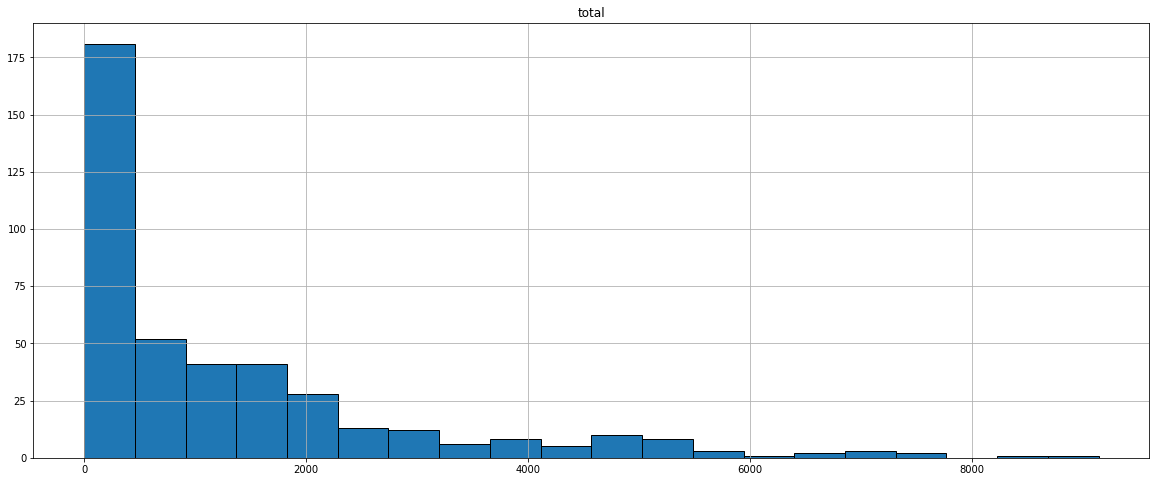

In [13]:
filtered.hist(column='total', bins=20, ec='black', figsize=(20,8))

# Describe the distribution statistics

### From the above plot, we can observe the following:

#### 1. The data are skewed, with a longer tail to the right (positive skew).
#### 2. Since the plot represent the number of covid cases, the data should be positive integers.
#### 3. The distribution is therefore a discrete distribution.

In [14]:
desc = total_state_cases.describe().apply(lambda x: round(x)).astype('int')[['total']]
desc = desc['total']
cases_mean = desc.loc['mean']
cases_median = desc.loc['50%']
cases_std = desc.loc['std']
cases_skew = total_state_cases.total.skew()
cases_kurt = total_state_cases.total.kurt()

In [15]:
md("""
## The distribution has the following moments:
##### &emsp;&emsp;mean: {0}
##### &emsp;&emsp;median: {1}
##### &emsp;&emsp;standard deviation: {2}
##### &emsp;&emsp;skewness: {3}
##### &emsp;&emsp;kurtosis: {4}
""".format(cases_mean, cases_median, cases_std, round(cases_skew, 4), round(cases_kurt,4)))


## The distribution has the following moments:
##### &emsp;&emsp;mean: 1360
##### &emsp;&emsp;median: 634
##### &emsp;&emsp;standard deviation: 1960
##### &emsp;&emsp;skewness: 3.8364
##### &emsp;&emsp;kurtosis: 30.9125


Since the standard deviation is in the same unit as X, it is much easier to interpret standard deviation than variance as variance has squared unit of X

In [16]:
def plot_hist(super_dataset, state: str):
    state_data = super_dataset[super_dataset.State == state]
    state_cases = state_data.drop([i for i in state_data.columns if "deaths" in i], axis=1)
    state_cases.columns = [i.replace("_cases", "") for i in state_cases.columns]
    # Slice dataframe, take columns from index 5 to the end (they are the date columns)
    # Find the sum (this gives the total number of cases per day)
    total_state_cases = pd.DataFrame(state_cases.iloc[:, 5:].sum(), columns=['total'])
    # Find difference between rows to get the number of new cases per day
    temp = total_state_cases.diff()
    # Replace first row of difference dataframe with first row of initial dataframe, to preserve the first values
    temp.iloc[0] = total_state_cases.iloc[0]
    total_state_cases = temp
    del temp
    total_state_cases['date'] = total_state_cases.index
    total_state_cases[["year", "week", "day"]] = pd.DataFrame(total_state_cases.date.apply(lambda x: datetime.strptime(x, "%Y-%m-%d").isocalendar()).to_list(), index=total_state_cases.index)
    total_state_cases.drop(['date', 'day'], axis=1, inplace=True)
    total_state_cases = total_state_cases.astype('int')
    # total_state_cases.hist(column='total', bins=20, ec='black', figsize=(20,8))
    # Remove any row that have negative values
    filtered = total_state_cases.loc[total_state_cases.total >= 0]
    # Remove the maximum value
    filtered = filtered[filtered.total != filtered.total.max()]
    filtered.hist(column='total', bins=20, ec='black', figsize=(20,8))
    return total_state_cases

<h3 style="text-align:center;"><br/><strong>Distribution for NY</strong><br/><br/></h3>

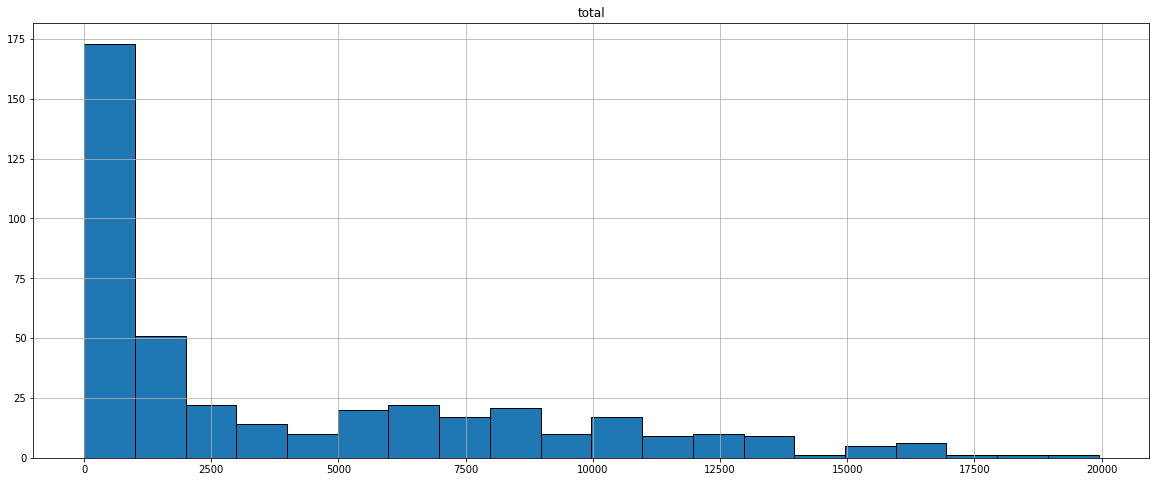

In [17]:
ny_data = plot_hist(super_dataset, 'NY')

In [18]:
desc = ny_data.describe().apply(lambda x: round(x)).astype('int')[['total']]
desc = desc['total']
cases_mean = desc.loc['mean']
cases_median = desc.loc['50%']
cases_std = desc.loc['std']
cases_skew = total_state_cases.total.skew()
cases_kurt = total_state_cases.total.kurt()

In [19]:
md("""
## The distribution has the following moments:
##### &emsp;&emsp;mean: {0}
##### &emsp;&emsp;median: {1}
##### &emsp;&emsp;standard deviation: {2}
##### &emsp;&emsp;skewness: {3}
##### &emsp;&emsp;kurtosis: {4}
""".format(cases_mean, cases_median, cases_std, round(cases_skew, 4), round(cases_kurt,4)))


## The distribution has the following moments:
##### &emsp;&emsp;mean: 4156
##### &emsp;&emsp;median: 1628
##### &emsp;&emsp;standard deviation: 4660
##### &emsp;&emsp;skewness: 3.8364
##### &emsp;&emsp;kurtosis: 30.9125


<h3 style="text-align:center;"><br/><strong>Distribution for MN</strong><br/><br/></h3>

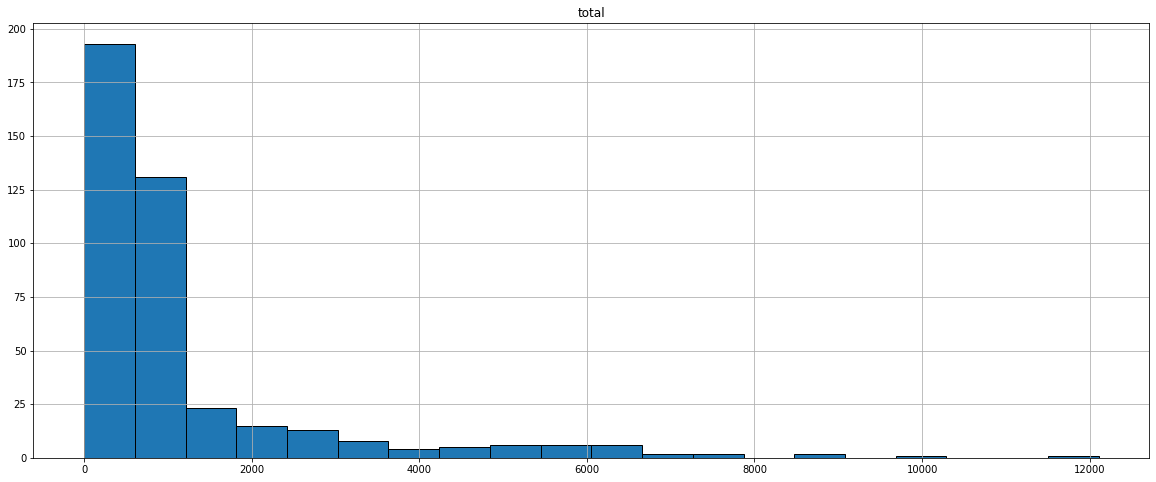

In [20]:
mn_data = plot_hist(super_dataset, 'MN')

In [21]:
desc = mn_data.describe().apply(lambda x: round(x)).astype('int')[['total']]
desc = desc['total']
cases_mean = desc.loc['mean']
cases_median = desc.loc['50%']
cases_std = desc.loc['std']
cases_skew = total_state_cases.total.skew()
cases_kurt = total_state_cases.total.kurt()

In [22]:
md("""
## The distribution has the following moments:
##### &emsp;&emsp;mean: {0}
##### &emsp;&emsp;median: {1}
##### &emsp;&emsp;standard deviation: {2}
##### &emsp;&emsp;skewness: {3}
##### &emsp;&emsp;kurtosis: {4}
""".format(cases_mean, cases_median, cases_std, round(cases_skew, 4), round(cases_kurt,4)))


## The distribution has the following moments:
##### &emsp;&emsp;mean: 1188
##### &emsp;&emsp;median: 663
##### &emsp;&emsp;standard deviation: 1900
##### &emsp;&emsp;skewness: 3.8364
##### &emsp;&emsp;kurtosis: 30.9125


<h3 style="text-align:center;"><br/><strong>Distribution for WY</strong><br/><br/></h3>

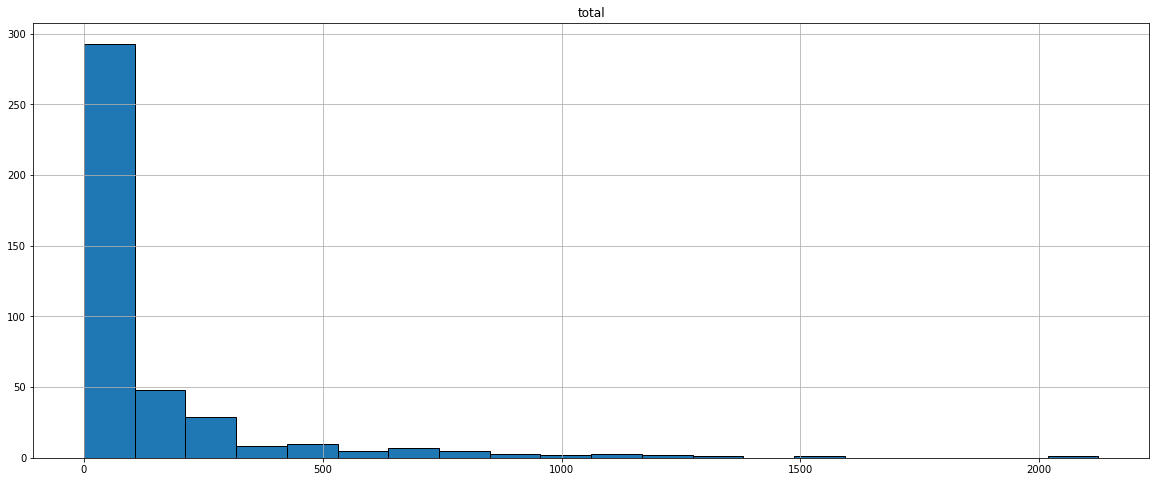

In [23]:
wy_data = plot_hist(super_dataset, 'WY')

In [24]:
desc = wy_data.describe().apply(lambda x: round(x)).astype('int')[['total']]
desc = desc['total']
cases_mean = desc.loc['mean']
cases_median = desc.loc['50%']
cases_std = desc.loc['std']
cases_skew = total_state_cases.total.skew()
cases_kurt = total_state_cases.total.kurt()

In [25]:
md("""
## The distribution has the following moments:
##### &emsp;&emsp;mean: {0}
##### &emsp;&emsp;median: {1}
##### &emsp;&emsp;standard deviation: {2}
##### &emsp;&emsp;skewness: {3}
##### &emsp;&emsp;kurtosis: {4}
""".format(cases_mean, cases_median, cases_std, round(cases_skew, 4), round(cases_kurt,4)))


## The distribution has the following moments:
##### &emsp;&emsp;mean: 132
##### &emsp;&emsp;median: 34
##### &emsp;&emsp;standard deviation: 338
##### &emsp;&emsp;skewness: 3.8364
##### &emsp;&emsp;kurtosis: 30.9125


<h3 style="text-align:center;"><br/><strong>Distribution for WA</strong><br/><br/></h3>

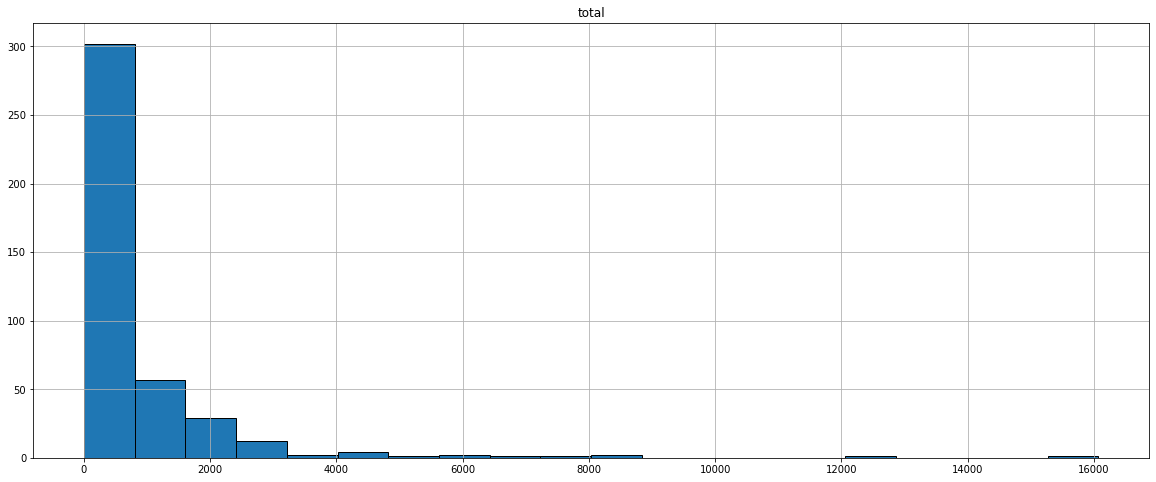

In [26]:
wa_data = plot_hist(super_dataset, 'WA')

In [27]:
desc = wa_data.describe().apply(lambda x: round(x)).astype('int')[['total']]
desc = desc['total']
cases_mean = desc.loc['mean']
cases_median = desc.loc['50%']
cases_std = desc.loc['std']
cases_skew = total_state_cases.total.skew()
cases_kurt = total_state_cases.total.kurt()

In [28]:
md("""
## The distribution has the following moments:
##### &emsp;&emsp;mean: {0}
##### &emsp;&emsp;median: {1}
##### &emsp;&emsp;standard deviation: {2}
##### &emsp;&emsp;skewness: {3}
##### &emsp;&emsp;kurtosis: {4}
""".format(cases_mean, cases_median, cases_std, round(cases_skew, 4), round(cases_kurt,4)))


## The distribution has the following moments:
##### &emsp;&emsp;mean: 836
##### &emsp;&emsp;median: 453
##### &emsp;&emsp;standard deviation: 1731
##### &emsp;&emsp;skewness: 3.8364
##### &emsp;&emsp;kurtosis: 30.9125


<h3 style="text-align:center;"><br/><strong>Distribution for CA</strong><br/><br/></h3>

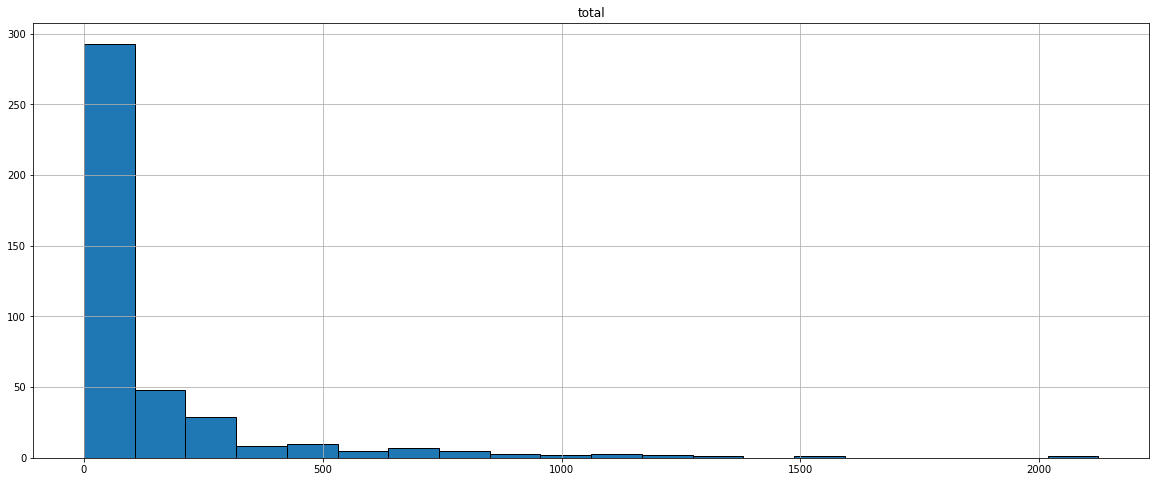

In [29]:
ca_data = plot_hist(super_dataset, 'WY')

In [30]:
desc = ca_data.describe().apply(lambda x: round(x)).astype('int')[['total']]
desc = desc['total']
cases_mean = desc.loc['mean']
cases_median = desc.loc['50%']
cases_std = desc.loc['std']
cases_skew = total_state_cases.total.skew()
cases_kurt = total_state_cases.total.kurt()

In [31]:
md("""
## The distribution has the following moments:
##### &emsp;&emsp;mean: {0}
##### &emsp;&emsp;median: {1}
##### &emsp;&emsp;standard deviation: {2}
##### &emsp;&emsp;skewness: {3}
##### &emsp;&emsp;kurtosis: {4}
""".format(cases_mean, cases_median, cases_std, round(cases_skew, 4), round(cases_kurt,4)))


## The distribution has the following moments:
##### &emsp;&emsp;mean: 132
##### &emsp;&emsp;median: 34
##### &emsp;&emsp;standard deviation: 338
##### &emsp;&emsp;skewness: 3.8364
##### &emsp;&emsp;kurtosis: 30.9125


<div class="alert-success">
    <h2 style="text-align:center;"><br/><strong>Model a poisson distribution of COVID cases and deaths for 5 states</strong><br/><br/></h2>
</div>

# Model a poisson distribution

To model a poisson distribution of COVID-19 cases and deaths, we need to find the mean value of cases and deaths. Then we can use poiss.pmf from scipy to calculate the probability at different values of covid cases and deaths.

To simplify the process, I have defined a function: 'get_poisson'. This function takes the following inputs:
1. DataFrame from where we find the number of cases and deaths
2. State abbreviation that helps us filter the dataframe by the abbreviation
3. Plotly Figure object where our function adds (plots) our distribution
4. of parameter (string) which tells us if we want the poisson distribution of 'cases' or 'deaths'
    * 'of' takes the value of 'cases' or 'deaths'
5. trunc_val (integer) that is used for better visualization
    * If we have a lot of data points after certain threshold that have very low probability, we might not be able to properly interpret from the visualization.
    * Remove values after this threshold would help us better visualize the data.

In [32]:
def get_poisson(dataset, state:str, fig, of:str, trunc_val:int=inf, per:int=100000):
    """
    Models poisson distribution from given dataset and writes to provided figure object.
    Returns manipulated dataframe, pmf and figure object.
    
    Input Params:
    dataset (pandas.core.Frame.DataFrame): dataframe to use to model the distribution of
    state (str): U.S. state abbreviation to filter our dataset for one particular state
    fig (plotly.graph_objs._figure.Figure): Plotly Figure object to plot our distribution upon
    of (str): parameter we are modeling distribution of ('cases' or 'deaths')
    trunc_val (int): optional parameter to use if we want to remove values after some threshold for better visualization
    
    """
    against = 'cases' if of == 'deaths' else 'deaths'
    state_data = dataset[(dataset.State == state) & (dataset.population != 0)]
    state_cases = state_data[[i for i in state_data.columns if against not in i]]
    state_cases.columns = [i.replace("_{0}".format(of), "") for i in state_cases.columns]
    total_cases = pd.DataFrame(state_cases.iloc[:, 4:].sum(), columns=['total'])
    new_cases = total_cases[1:].diff()
    new_cases.iloc[0] = total_cases.iloc[1]
    population = int(total_cases.iloc[0])
    # Extract year and week for each row
    new_cases['date'] = new_cases.index
    new_cases[["year", "week", "day"]] = pd.DataFrame(new_cases.date.apply(lambda x: datetime.strptime(x, "%Y-%m-%d").isocalendar()).to_list(), index=new_cases.index)
    new_cases.drop(['date', 'day'], axis=1, inplace=True)
    new_cases['total'] = new_cases.total.apply(lambda x: x/population*per).round().astype('int')
    # Only consider the data after first day of new covid cases
    new_cases = new_cases.loc[new_cases[new_cases.total > 0].index[0]:]
    # If any entry have negative values, they are false observations, so replace them with mean value
    temp = new_cases[new_cases.total > 0]
    mu = temp.total.mean()
    new_cases.loc[new_cases.total < 0, 'total'] = int(round(mu))
    del temp
    mu = new_cases.total.mean()
    x, prob = [], []
    for i in range(new_cases.total.min(), new_cases.total.max()+1):
        x.append(i)
        prob.append(poisson.pmf(k=i,mu=mu))
    poiss = pd.DataFrame({"x":x, "probability": prob})
    poiss.drop(poiss[poiss.x > trunc_val].index, inplace=True)
    fig.add_trace(go.Scatter(x=poiss.x, y=poiss.probability, mode='lines+markers', name="{0}, λ = {1}".format(state, int(round(mu)))))
    return new_cases, poiss, fig

In [33]:
fig = go.Figure()
states = ['NY', 'MN', 'WY', 'WA', 'CA']
for i in states:
    df, poiss, fig = get_poisson(super_dataset, i, fig, of='cases')
fig.update_layout(
    title="Poisson Distribution<br>Probability Mass Function",
    title_x=0.5,
    xaxis_title="Number of covid cases per 100,000 (k)",
    yaxis_title="Probability P(X=k)",
    height=500,
)
print()

## Poisson distribution of COVID-19 cases for NY, MN, WY, WA and CA

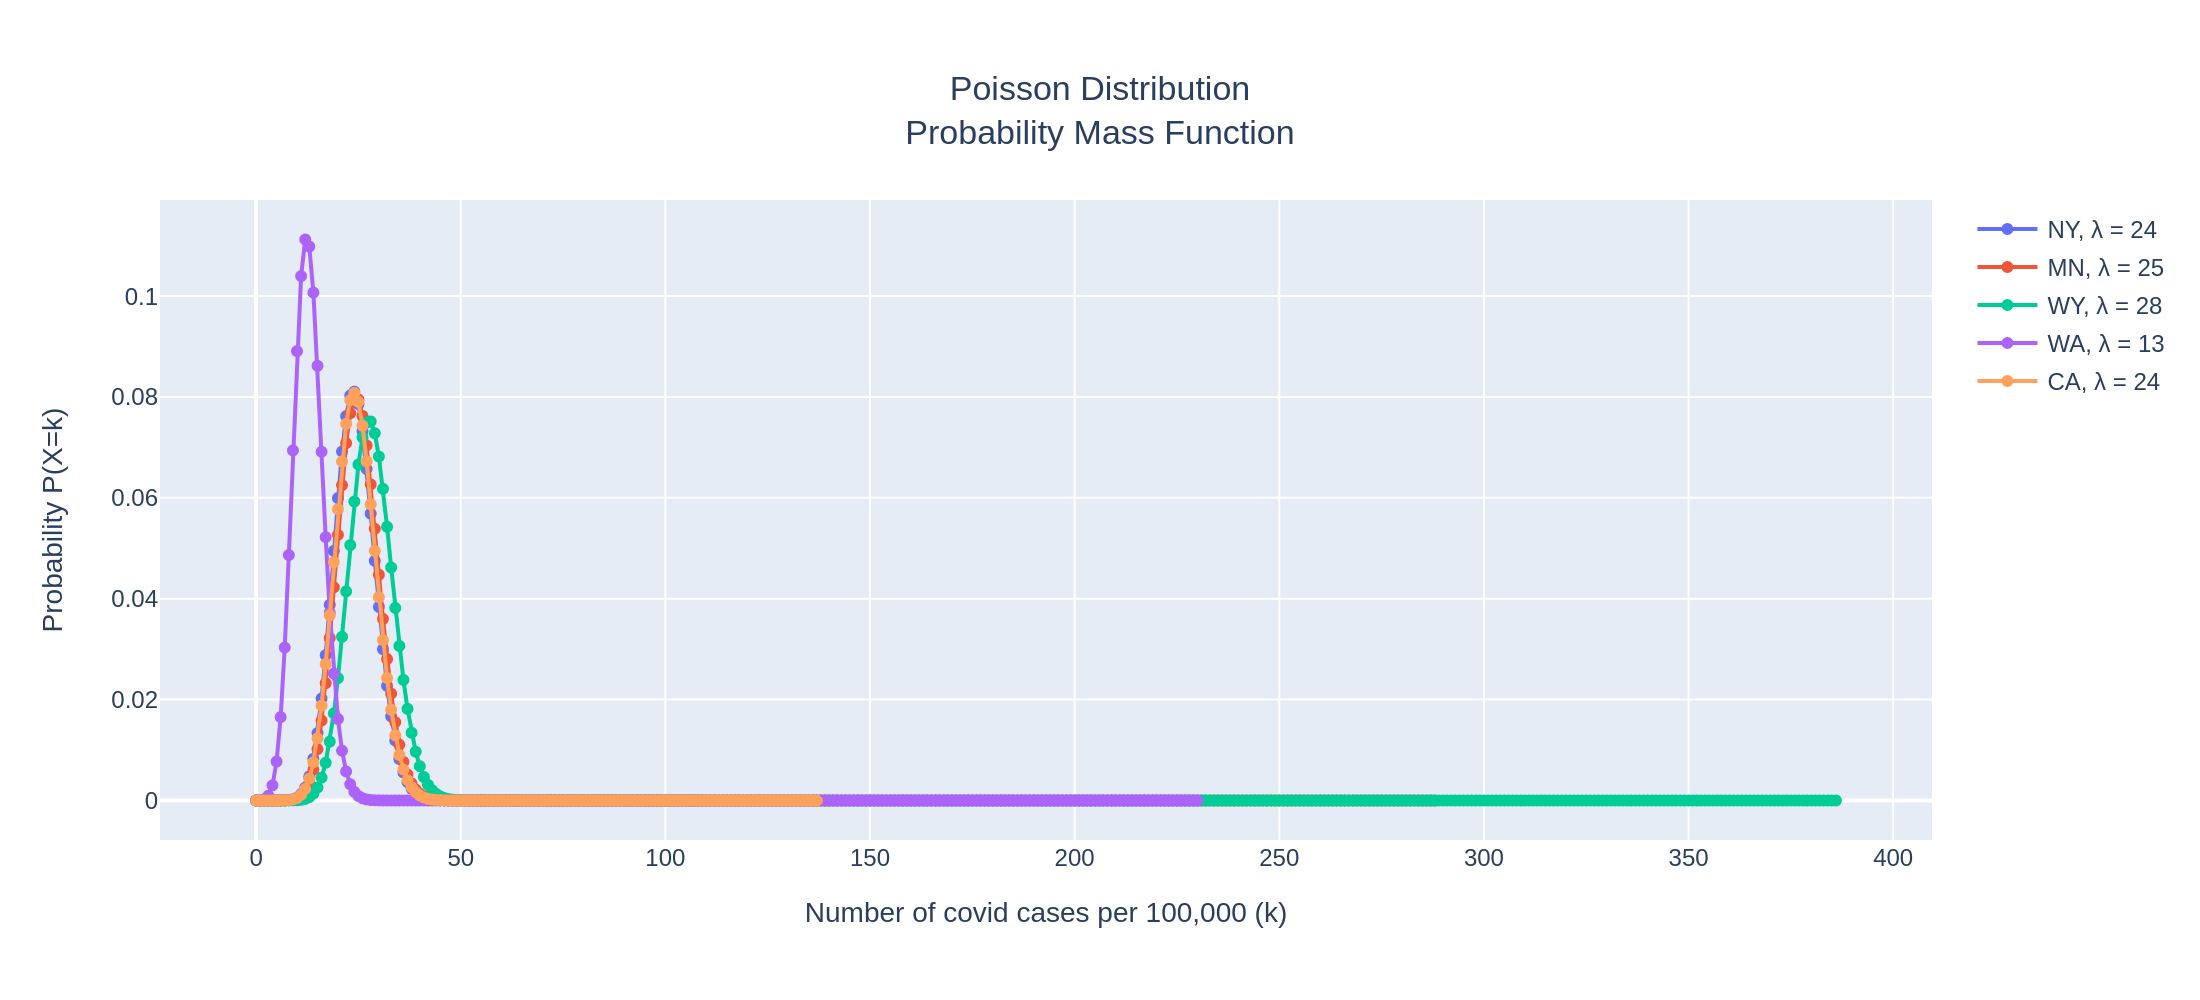

In [34]:
# fig.show()
img_bytes = fig.to_image(format="png", width=1100, height=500, scale=2)
Image(img_bytes)

As we can see from the above figure, we have very low probality for cases after 70 or so. And since the value stretches to nearly 400, the visualization is less interpretable. To help visualize the data, we can remove values that are of less importance.

In our case, we can remove values after 70. To do so, we need to pass trunc_val parameter to the above defined function.
Lets pass the value of 70 and see how our graph changes.

In [35]:
fig = go.Figure()
states = ['NY', 'MN', 'WY', 'WA', 'CA']
for i in states:
    df, poiss, fig = get_poisson(super_dataset, i, fig, of='cases', trunc_val=70)
fig.update_layout(
    title="Poisson Distribution<br>Probability Mass Function",
    title_x=0.5,
    xaxis_title="Number of covid cases per 100,000 (k)",
    yaxis_title="Probability P(X=k)",
    height=500,
)
print()

## Poisson distribution of COVID-19 cases (Better visualization)

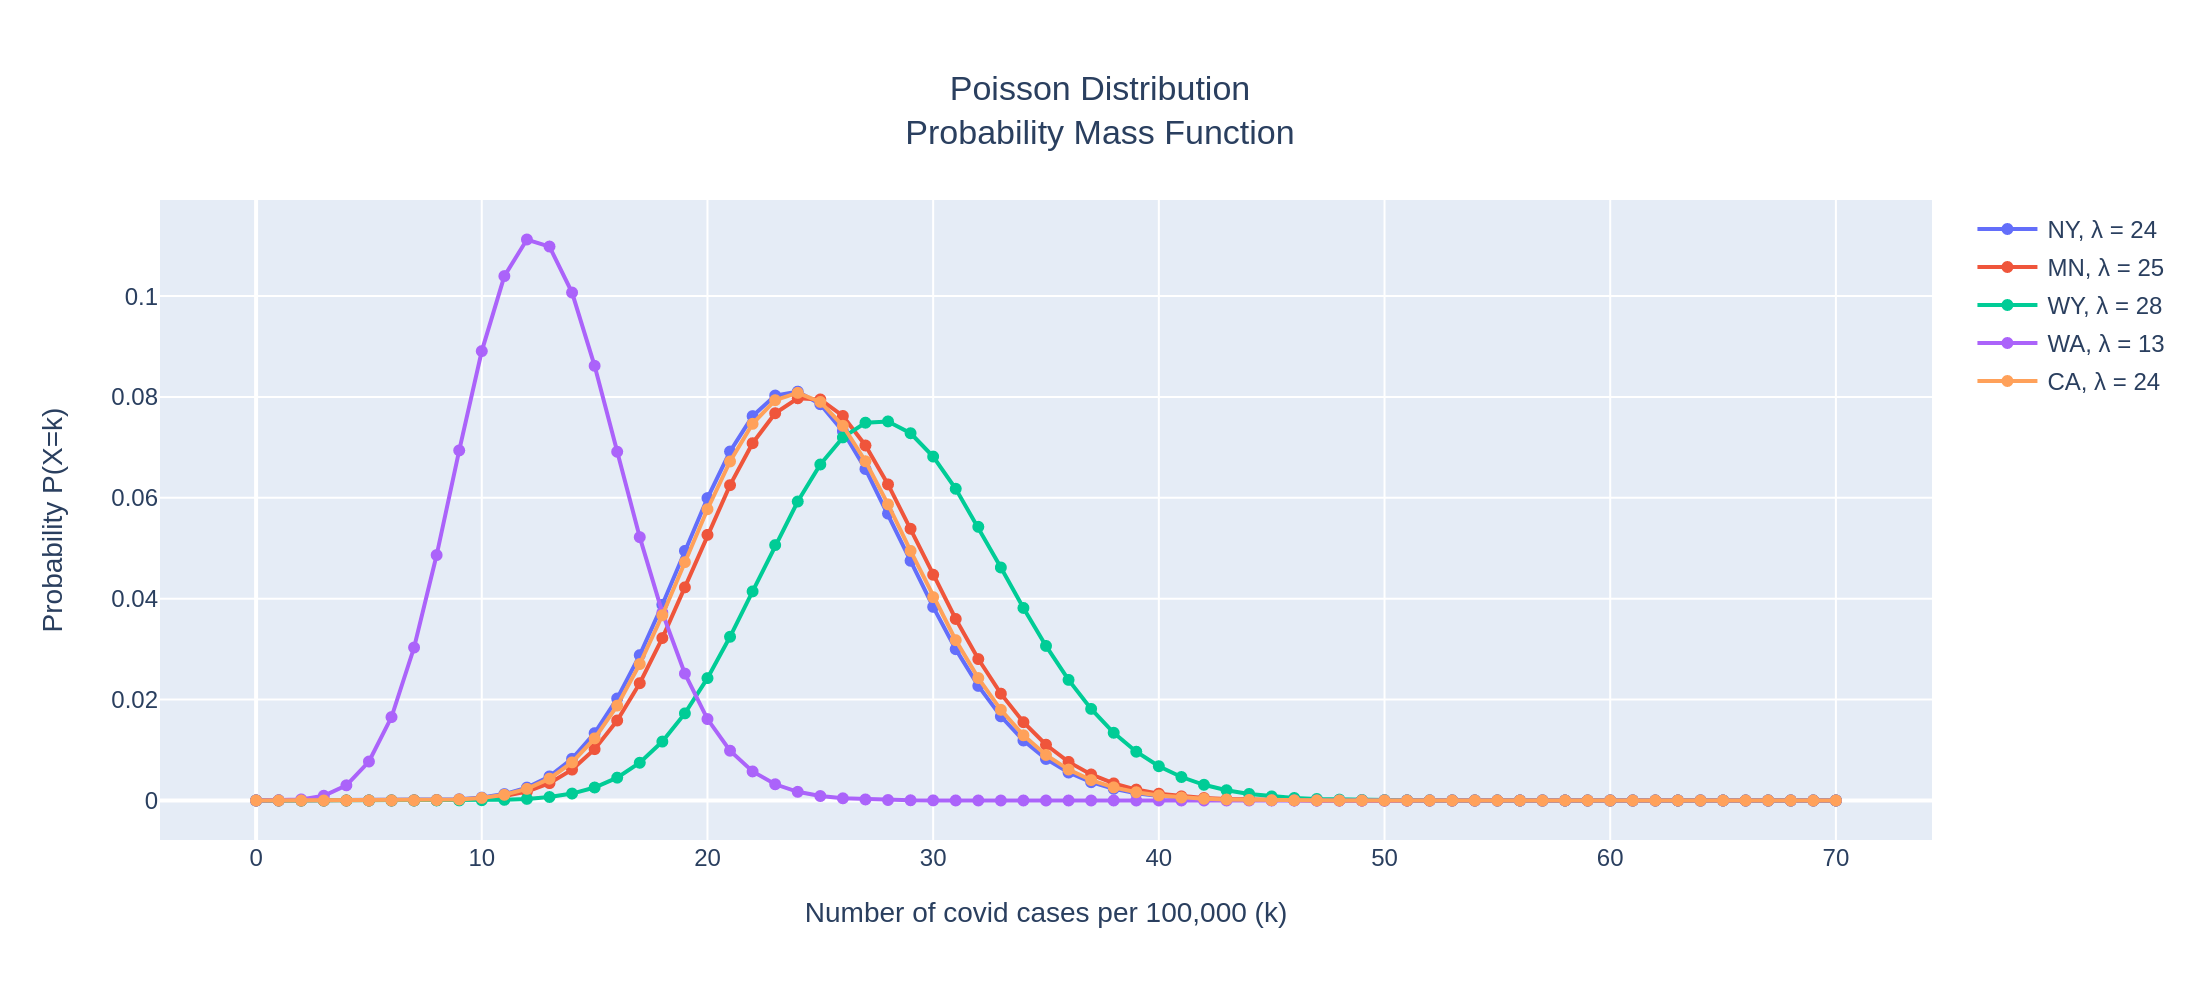

In [36]:
# fig.show()
img_bytes = fig.to_image(format="png", width=1100, height=500, scale=2)
Image(img_bytes)

Now its much easier to visualize the information.

Lets interpret the above plot.

All the values are normalized to 100,000 population. So the values we see are the number of covid cases per 100,000 population. From the first figure, we can observe that Wyoming (WY) has observed covid cases as high as 386 in a single day. Washington (WA) has observed cases as high as 230 in a day. California (CA) has observed highest covid case of 137 in at least a day.

From the second figure, we can clearly observe the difference in number of covid cases across the 5 states. Among these states, Washington (WA) has the lowest mean number of daily cases at 13. Wyoming (WY) has highest mean number of COVID cases per day, average of 28. The other three states have similar mean daily cases at 24 and 25.

It seems that Washington is doing better than other states in terms of controlling the spread of covid cases as they have relatively low mean number of daily cases. Wyoming, on the other hand, seems to have a hard time controlling the spread as they have relatively high number of cases per day. Minnesota, New York and California seems to perform similarly in controlling the spread. They follow each other closely in terms of peak as well as spread.

To observe the skewness, we need to analyze the first figure. As we can see in the first figure, all 5 distribution have tail to the right and so, they all have positive skew.
WY has the longest tail to the right, and hence it has the highest positive skew, followed by Washington. We can use the skew method of pandas to find the skewness of each of the distribution.

To find the kurtosis, we can use the kurt method of pandas.

In [37]:
states = ['NY', 'MN', 'WY', 'WA', 'CA']
for i in states:
    df, poiss, fig = get_poisson(super_dataset, i, fig, of='cases')
    print(i, 'skew:', poiss.probability.skew(), 'kurtosis:', poiss.probability.kurt())

NY skew: 2.4072781244272754 kurtosis: 4.575768977047268
MN skew: 4.373136351230239 kurtosis: 18.73709121072971
WY skew: 4.98001565039944 kurtosis: 24.752977610083203
WA skew: 4.659825848675306 kurtosis: 21.536189907178358
CA skew: 2.8057207058928135 kurtosis: 6.786361118661299


<br/>
From the result, we can conclude that Wyoming has highest positive skew, followed by Washington, Minnesota, California and New York.

Also, Wyoming has highest kurtosis, followed by Washington, Minnesota, California and New York. This suggests that the probability of observing 28 cases in a day in Wyoming is much higher than the probability of observing 24 cases in a day in New York. Since our distribution is not symmetrical, we cannot simply look at the plots to figure out the peakness. 

## Poisson distribution of COVID-19 deaths for NY, MN, WY, WA and CA

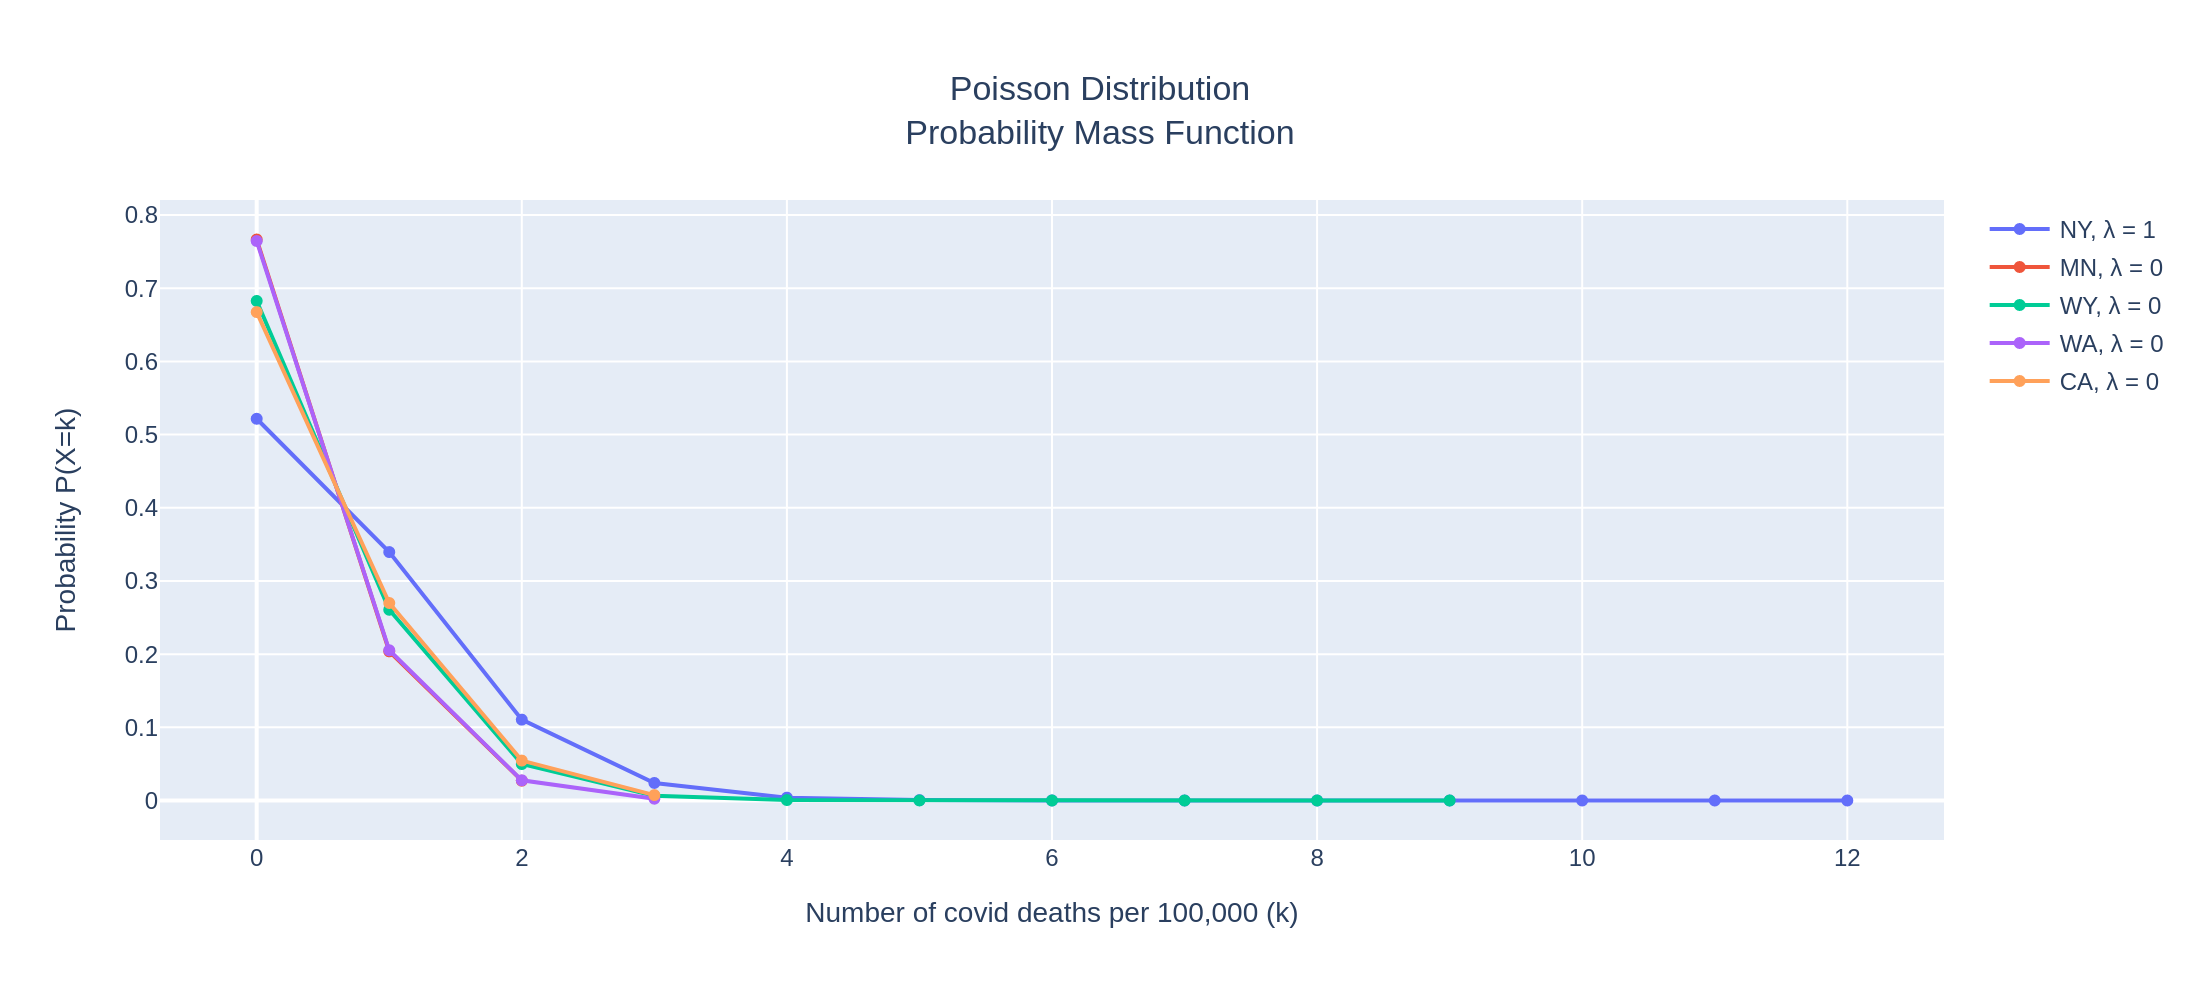

In [38]:
fig = go.Figure()
states = ['NY', 'MN', 'WY', 'WA', 'CA']
for i in states:
    df, poiss, fig = get_poisson(super_dataset, i, fig, of='deaths')
fig.update_layout(
    title="Poisson Distribution<br>Probability Mass Function",
    title_x=0.5,
    xaxis_title="Number of covid deaths per 100,000 (k)",
    yaxis_title="Probability P(X=k)",
    height=500,
)
# fig.show()
img_bytes = fig.to_image(format="png", width=1100, height=500, scale=2)
Image(img_bytes)

From the figure above, we can observe that the number of deaths per 100,000 has not given enough information to properly intrepret the graph. Instead, we can choose to observe the number of deaths on a higher population. Since these states have population in millions, and the number of deaths per day per state might not be very high, we can take the number of deaths per 1,000,000 or even 10,000,000.

To clarify, lets take an example. If some state has 2 deaths where the population of the state is around 10,000,000. If we normalize the number of cases to around 100,000, the number of deaths will be 0. So here, we lost the crucial information of number of deaths. And because the number of deaths in intial stage were in the order of 1's or 10's, there is very high chance that we miss these information. So lets try to normalize the number of deaths to around 10,000,000.

## Poisson distribution of COVID-19 deaths (Better visualization)

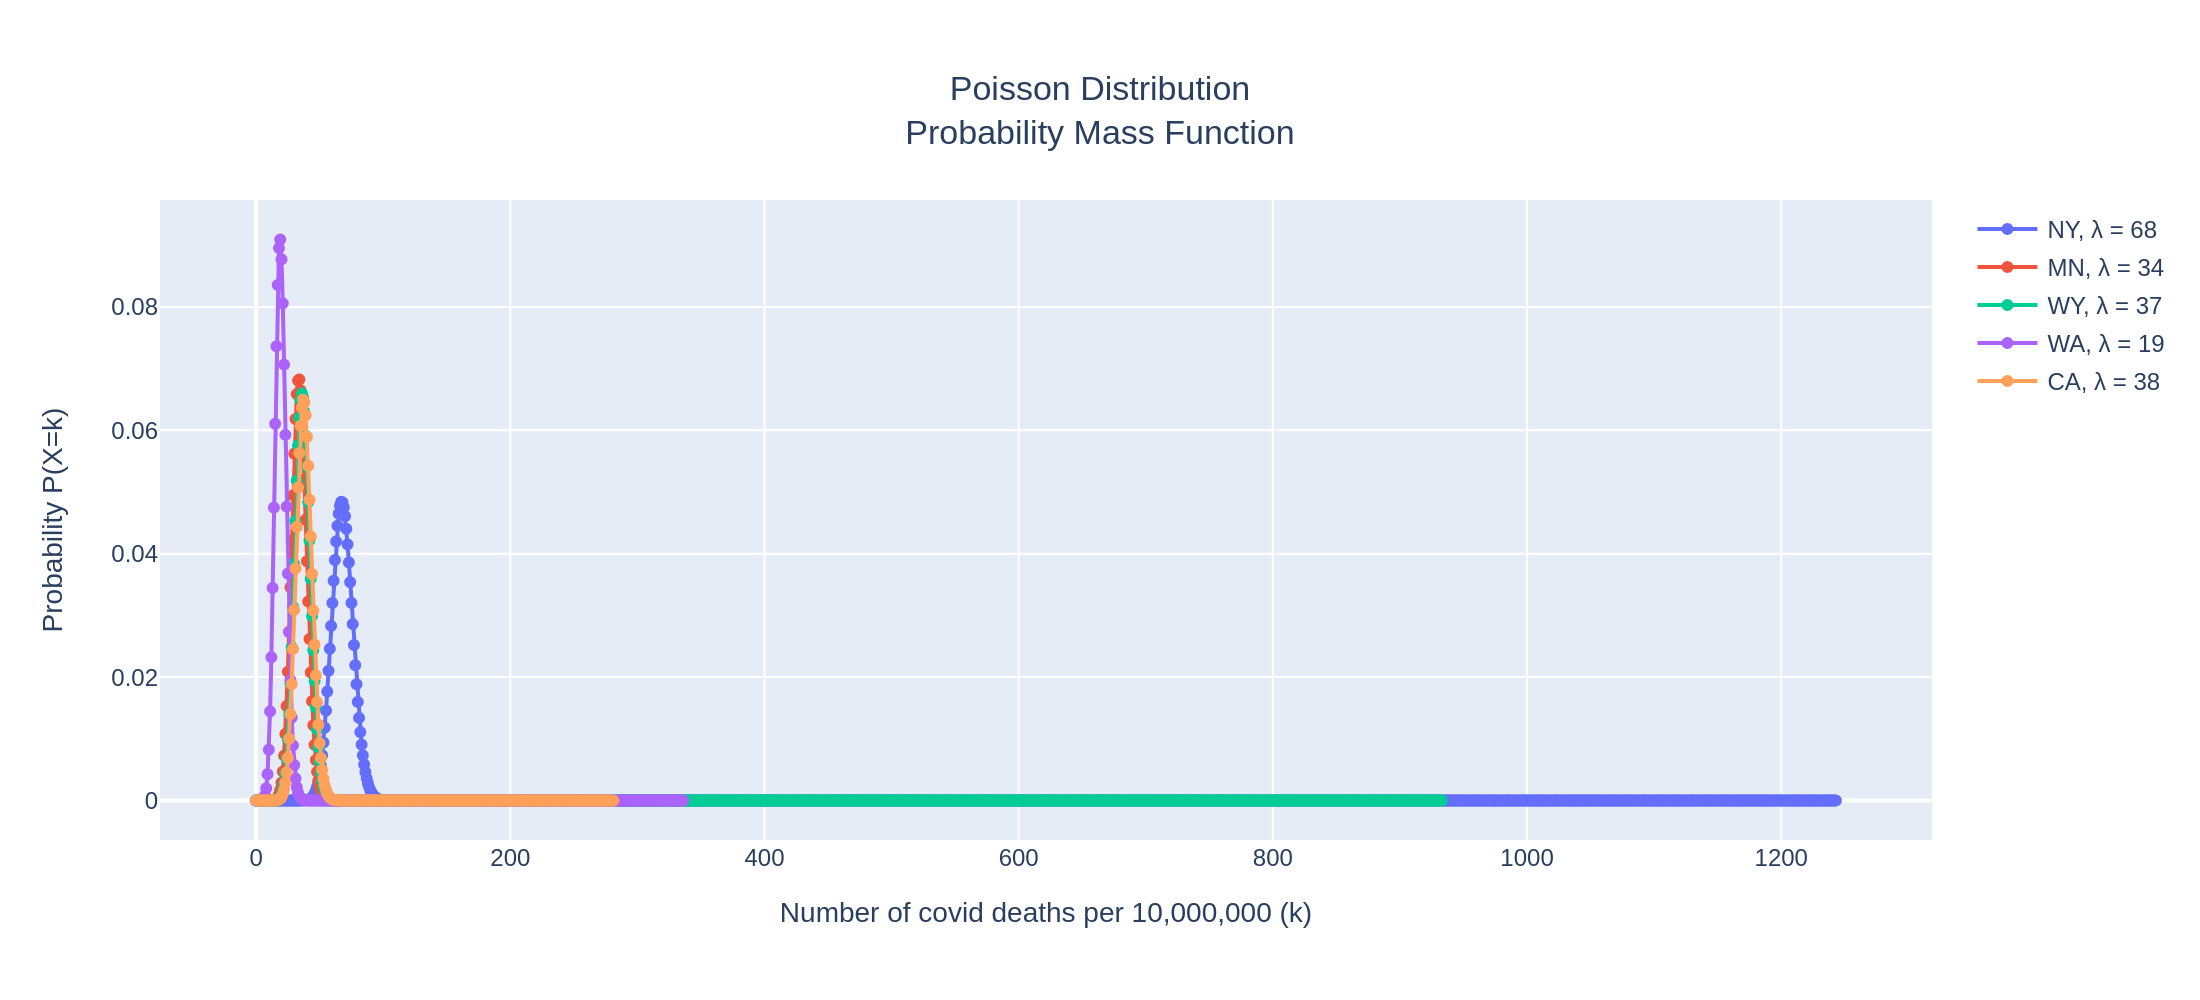

In [39]:
fig = go.Figure()
states = ['NY', 'MN', 'WY', 'WA', 'CA']
for i in states:
    df, poiss, fig = get_poisson(super_dataset, i, fig, of='deaths', per=10000000)
fig.update_layout(
    title="Poisson Distribution<br>Probability Mass Function",
    title_x=0.5,
    xaxis_title="Number of covid deaths per 10,000,000 (k)",
    yaxis_title="Probability P(X=k)",
    height=500,
)
# fig.show()
img_bytes = fig.to_image(format="png", width=1100, height=500, scale=2)
Image(img_bytes)

The figure above is much more interpretable and we can observe the distribution more clearly in this plot.

However, just like in covid cases, we have very low probality for deaths after 150 or so. And since the value stretches to nearly 1250, the visualization is less interpretable. To help visualize the data, we can remove values that are of less importance.

In our case, we can remove values after 130. To do so, we need to pass trunc_val parameter to the above defined function.
Lets pass the value of 130 and see how our graph changes.

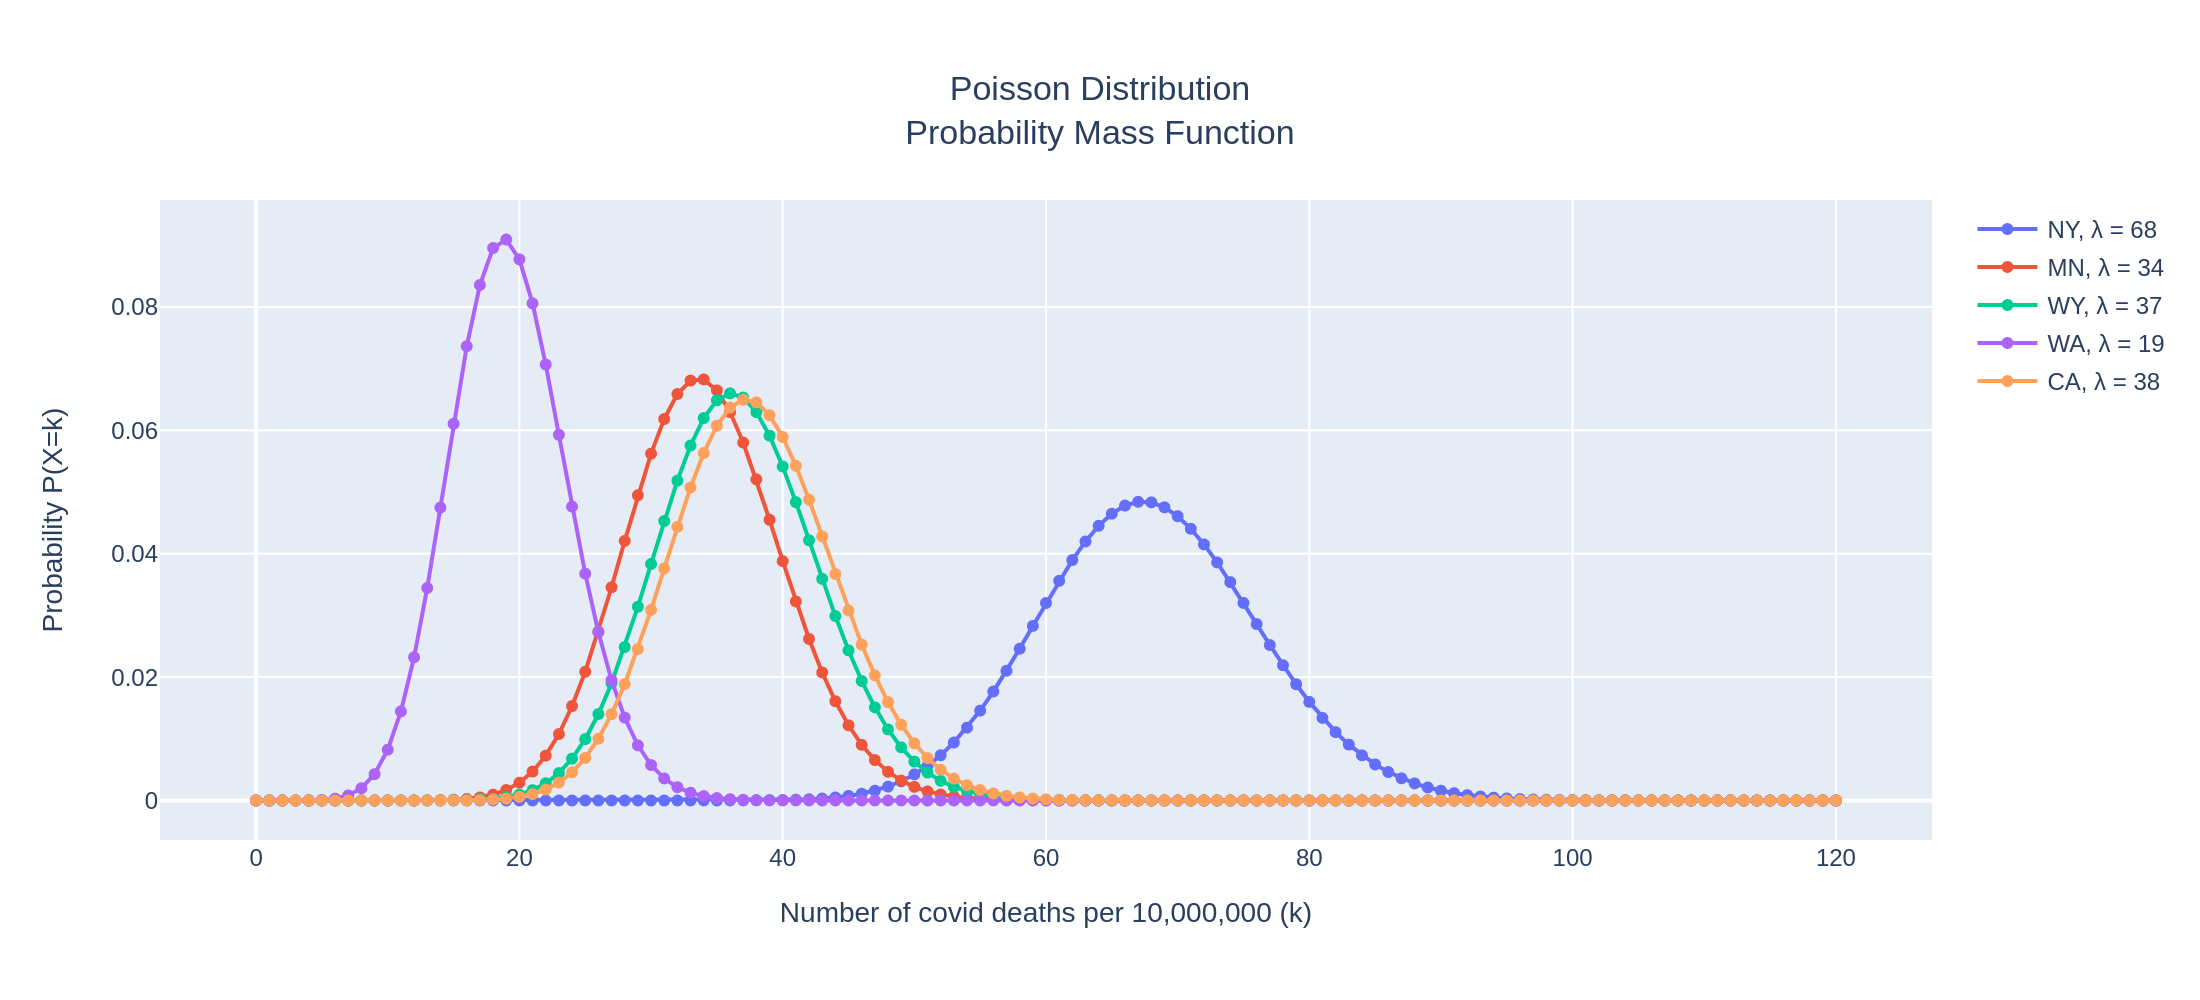

In [40]:
fig = go.Figure()
states = ['NY', 'MN', 'WY', 'WA', 'CA']
for i in states:
    df, poiss, fig = get_poisson(super_dataset, i, fig, of='deaths', per=10000000, trunc_val=120)
fig.update_layout(
    title="Poisson Distribution<br>Probability Mass Function",
    title_x=0.5,
    xaxis_title="Number of covid deaths per 10,000,000 (k)",
    yaxis_title="Probability P(X=k)",
    height=500,
)
# fig.show()
img_bytes = fig.to_image(format="png", width=1100, height=500, scale=2)
Image(img_bytes)

Now its much easier to visualize the information.

Lets interpret the above plot.

All the values are normalized to 10,000,000 population. So the values we see are the number of covid deaths per 10,000,000 population. From the first figure, we can observe that New York (NY) has observed covid deatlhs as high as 1243 in a single day. Wyoming (WY) has observed deaths as high as 933 in a day.

From the second figure, we can clearly observe the difference in number of covid deaths across the 5 states. Among these states, Washington (WA) has the lowest mean number of daily deaths at 19. New York (NY) has highest mean number of COVID cases per day, average of 68. The other three states have similar mean daily cases at 34, 37 and 38.

It seems that Washington is doing better than other states in controlling death rates as they have relatively low mean number of deaths per day. New York, on the other hand, seems to have a hard time controlling the death rates as they have relatively high number of deaths per day. Minnesota, New York and California seems to perform similarly in controlling the death rates. They follow each other closely in terms of peak as well as spread.

In [41]:
fig = go.Figure()
states = ['NY', 'MN', 'WY', 'WA', 'CA']
for i in states:
    df, poiss, fig = get_poisson(super_dataset, i, fig, of='deaths', per=10000000)
    print(i, 'skew:', poiss.probability.skew(), 'kurtosis:', poiss.probability.kurt())

NY skew: 7.35178306459033 kurtosis: 55.73279788237095
MN skew: 3.6553765887261904 kurtosis: 12.601881676788881
WY skew: 7.441207325317562 kurtosis: 57.165948857752646
WA skew: 5.1238337036234345 kurtosis: 26.320396362564367
CA skew: 3.817697328862985 kurtosis: 13.88451126953623


From the result, we can conclude that Washington has highest positive skew, followed by Minnesota, Wyoming, California and New York.

Also, Washington has highest kurtosis, followed by Minnesota, Wyoming, California and New York. This suggests that the probability of observing 19 deaths per 10 million people in a day in Washington is much higher than the probability of observing 68 deaths per 10 million people in a day in New York.

<div class="alert-success">
    <h2 style="text-align:center;"><br/><strong>Model a poisson distribution of COVID cases and deaths for 5 counties in NC</strong><br/><br/></h2>
</div>

### Function Definition to get poisson distribution for county

In [42]:
def get_poisson_county(dataset, county:str, fig, of:str, trunc_val:int=inf, per:int=100000):
    """
    Models poisson distribution from given dataset and writes to provided figure object.
    Returns manipulated dataframe, pmf and figure object.
    
    Input Params:
    dataset (pandas.core.Frame.DataFrame): dataframe to use to model the distribution of
    county (int): State countyFIPS to filter our dataset for one particular county
    fig (plotly.graph_objs._figure.Figure): Plotly Figure object to plot our distribution upon
    of (str): parameter we are modeling distribution of ('cases' or 'deaths')
    trunc_val (int): optional parameter to use if we want to remove values after some threshold for better visualization    
    """
    against = 'cases' if of == 'deaths' else 'deaths'
    county_data = dataset[(dataset.countyFIPS == county) & (dataset.population != 0)]
    county_cases = county_data[[i for i in county_data.columns if against not in i]]
    county_cases.columns = [i.replace("_{0}".format(of), "") for i in county_cases.columns]
    county_cases.index = county_cases.countyFIPS
    new_cases = county_cases.iloc[:, 5:].diff(axis=1)
    new_cases.iloc[:,0] = county_cases.iloc[:,5]
    population = int(county_cases['population'])
    new_cases = new_cases.apply(lambda x: x/population*per).round().astype('int')
    new_cases = new_cases.T
    # Only consider the data after first day of new covid cases
    new_cases = new_cases[new_cases[(new_cases > 0).any(axis=1)].index[0]:]
    # If any entry have negative values, they are false observations, so replace them with mean value
    temp = new_cases[new_cases[county] > 0]
    mu = temp[county].mean()
    new_cases.loc[new_cases[county] < 0, county] = int(round(mu))
    del temp
    mu = new_cases[county].mean()
    x, prob = [], []
    for i in range(new_cases[county].min(), new_cases[county].max()+1):
        x.append(i)
        prob.append(poisson.pmf(k=i,mu=mu))
    poiss = pd.DataFrame({"x":x, "probability": prob})
    poiss.drop(poiss[poiss.x > trunc_val].index, inplace=True)
    county_name = county_cases['County Name'][county].replace(" County", "")
    fig.add_trace(go.Scatter(x=poiss.x, y=poiss.probability, mode='lines+markers', 
                             name="{0}, λ = {1}".format(county_name, int(round(mu)))))
    return new_cases, poiss, fig

In [43]:
fig = go.Figure()
nc_data = super_dataset[(super_dataset.State == "NC") & (super_dataset.population != 0)]
counties = [37043, 37081, 37119, 37135, 37183]
for i in counties:
    df, poiss, fig = get_poisson_county(nc_data, i, fig, of='cases')
fig.update_layout(
    title="Poisson Distribution<br>Probability Mass Function",
    title_x=0.5,
    xaxis_title="Number of covid cases per 100,000 (k)",
    yaxis_title="Probability P(X=k)",
    height=500,
)
print()

## Poisson distribution of COVID-19 cases for 5 counties of NC

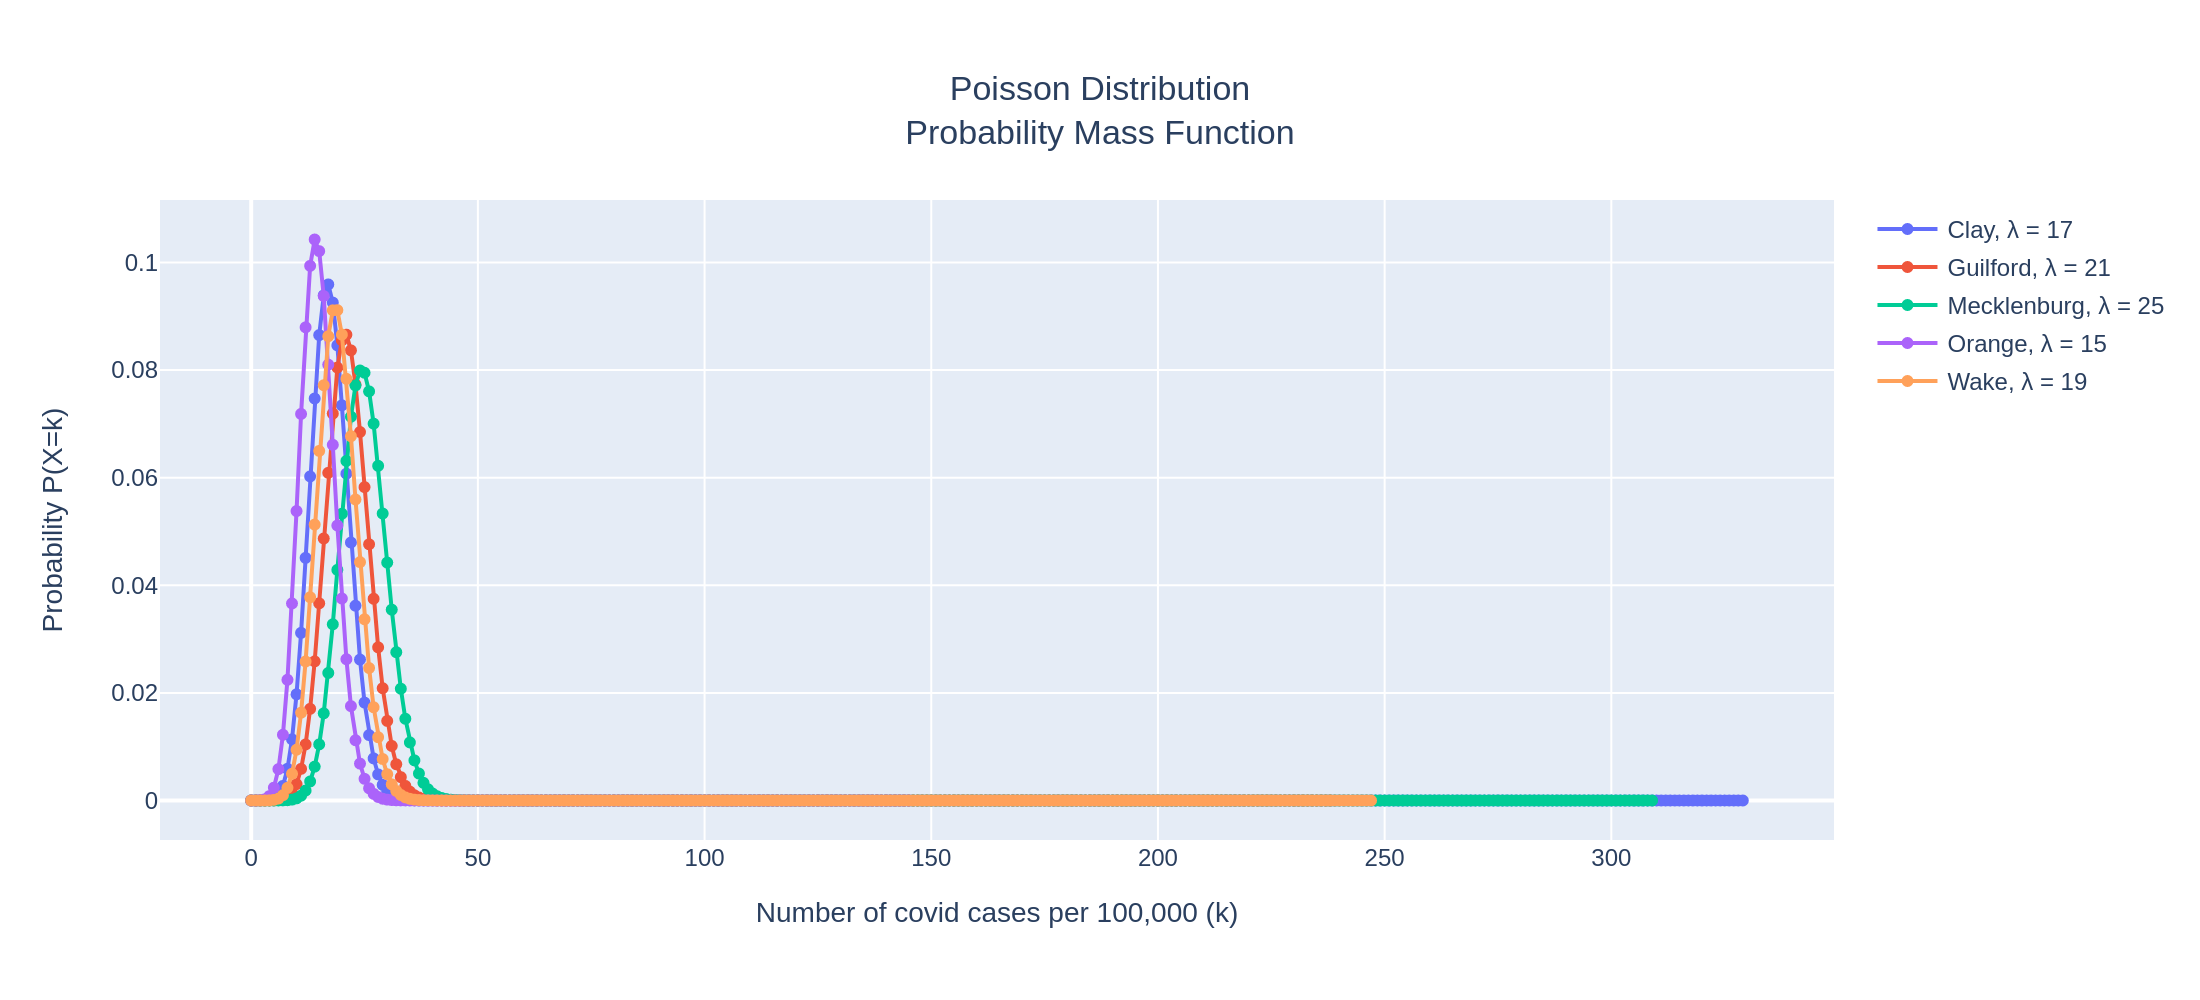

In [44]:
# fig.show()
img_bytes = fig.to_image(format="png", width=1100, height=500, scale=2)
Image(img_bytes)

In [45]:
nc_data = super_dataset[(super_dataset.State == "NC") & (super_dataset.population != 0)]
counties = [37043, 37081, 37119, 37135, 37183]
for i in counties:
    df, poiss, fig = get_poisson_county(nc_data, i, fig, of='cases')
    print(nc_data[nc_data.countyFIPS==i].values[0][1], 'skew:', poiss.probability.skew(), 'kurtosis:', poiss.probability.kurt())

Clay County skew: 5.21531852785784 kurtosis: 27.332045638967326
Guilford County skew: 4.107417455003186 kurtosis: 16.355603159611498
Mecklenburg County skew: 4.553572537799473 kurtosis: 20.446677742357135
Orange County skew: 3.428672688014066 kurtosis: 10.949062510432023
Wake County skew: 4.334448732399539 kurtosis: 18.39806365139945


## Poisson distribution of COVID-19 cases (Better visualization)

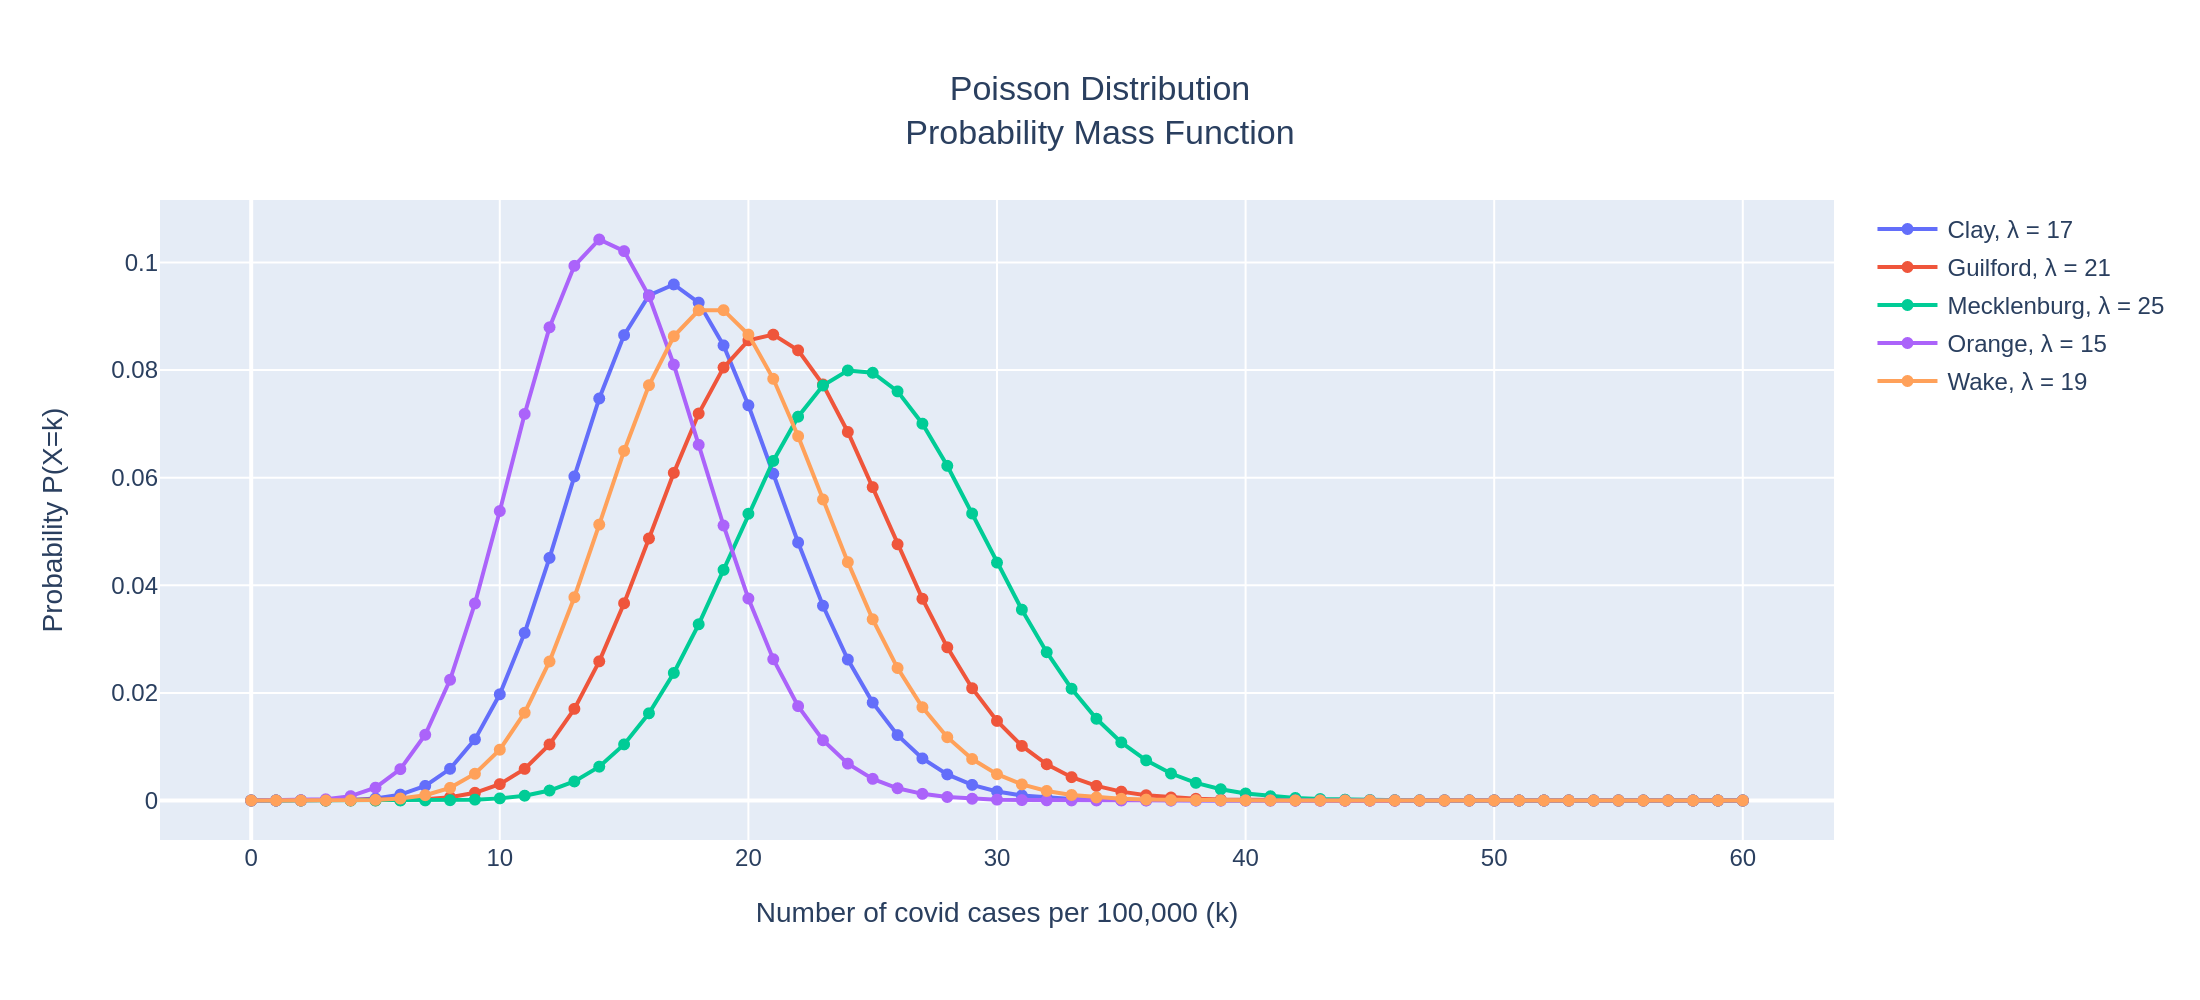

In [46]:
fig = go.Figure()
nc_data = super_dataset[(super_dataset.State == "NC") & (super_dataset.population != 0)]
counties = [37043, 37081, 37119, 37135, 37183]
for i in counties:
    df, poiss, fig = get_poisson_county(nc_data, i, fig, of='cases', trunc_val=60)
fig.update_layout(
    title="Poisson Distribution<br>Probability Mass Function",
    title_x=0.5,
    xaxis_title="Number of covid cases per 100,000 (k)",
    yaxis_title="Probability P(X=k)",
    height=500,
)
# fig.show()
img_bytes = fig.to_image(format="png", width=1100, height=500, scale=2)
Image(img_bytes)

## Poisson distribution of COVID-19 cases for 5 counties of NC

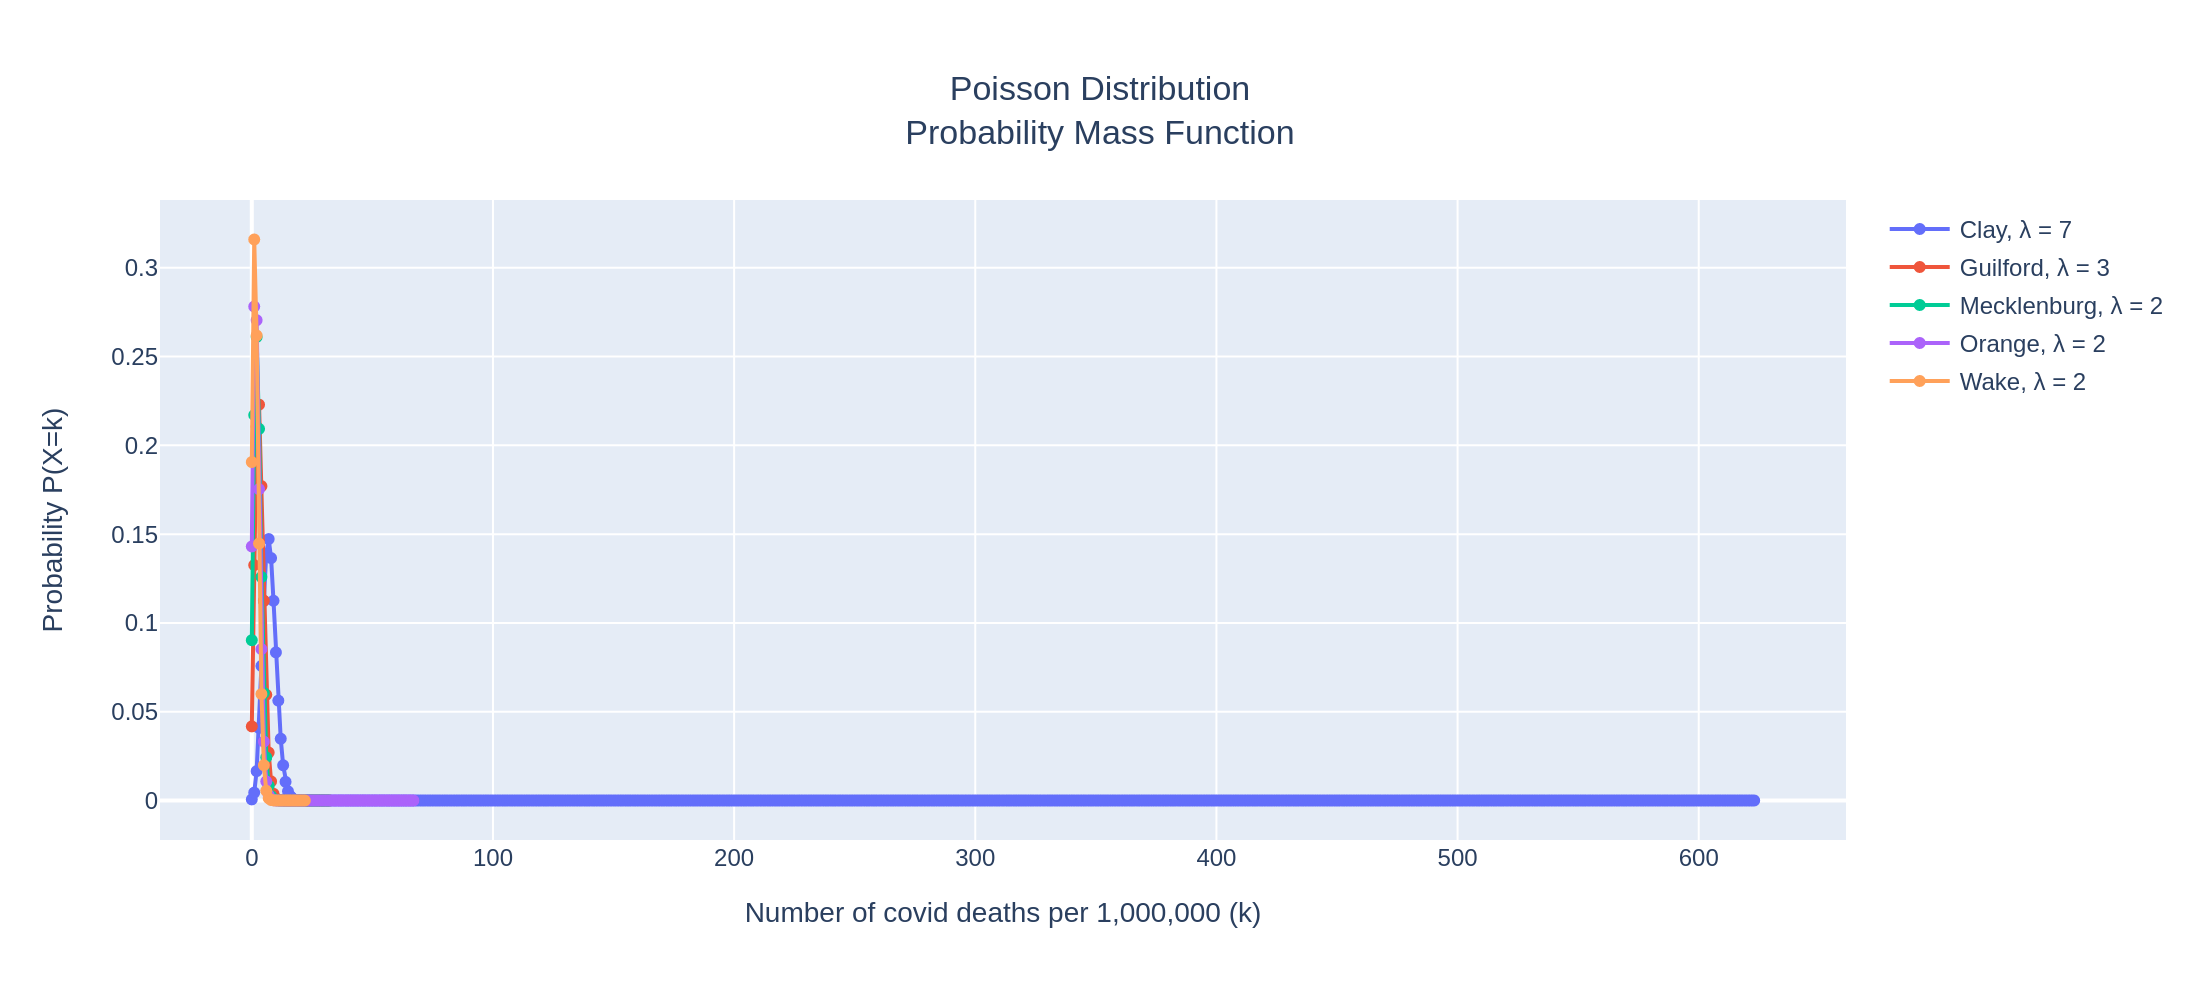

In [47]:
fig = go.Figure()
nc_data = super_dataset[(super_dataset.State == "NC") & (super_dataset.population != 0)]
counties = [37043, 37081, 37119, 37135, 37183]
for i in counties:
    df, poiss, fig = get_poisson_county(nc_data, i, fig, of='deaths', per=1000000)
fig.update_layout(
    title="Poisson Distribution<br>Probability Mass Function",
    title_x=0.5,
    xaxis_title="Number of covid deaths per 1,000,000 (k)",
    yaxis_title="Probability P(X=k)",
    height=500,
)
# fig.show()
img_bytes = fig.to_image(format="png", width=1100, height=500, scale=2)
Image(img_bytes)

In [48]:
nc_data = super_dataset[(super_dataset.State == "NC") & (super_dataset.population != 0)]
counties = [37043, 37081, 37119, 37135, 37183]
for i in counties:
    df, poiss, fig = get_poisson_county(nc_data, i, fig, of='deaths', per=1000000)
    print(nc_data[nc_data.countyFIPS==i].values[0][1], 'skew:', poiss.probability.skew(), 'kurtosis:', poiss.probability.kurt())

Clay County skew: 9.168024084703697 kurtosis: 87.70400997270728
Guilford County skew: 2.1673965781363487 kurtosis: 3.560253818223312
Mecklenburg County skew: 2.4136226168398873 kurtosis: 4.827211006805896
Orange County skew: 4.042670206354561 kurtosis: 16.14930844063786
Wake County skew: 2.1414435844482593 kurtosis: 3.5633558123633478


## Poisson distribution of COVID-19 cases (Better visualization)

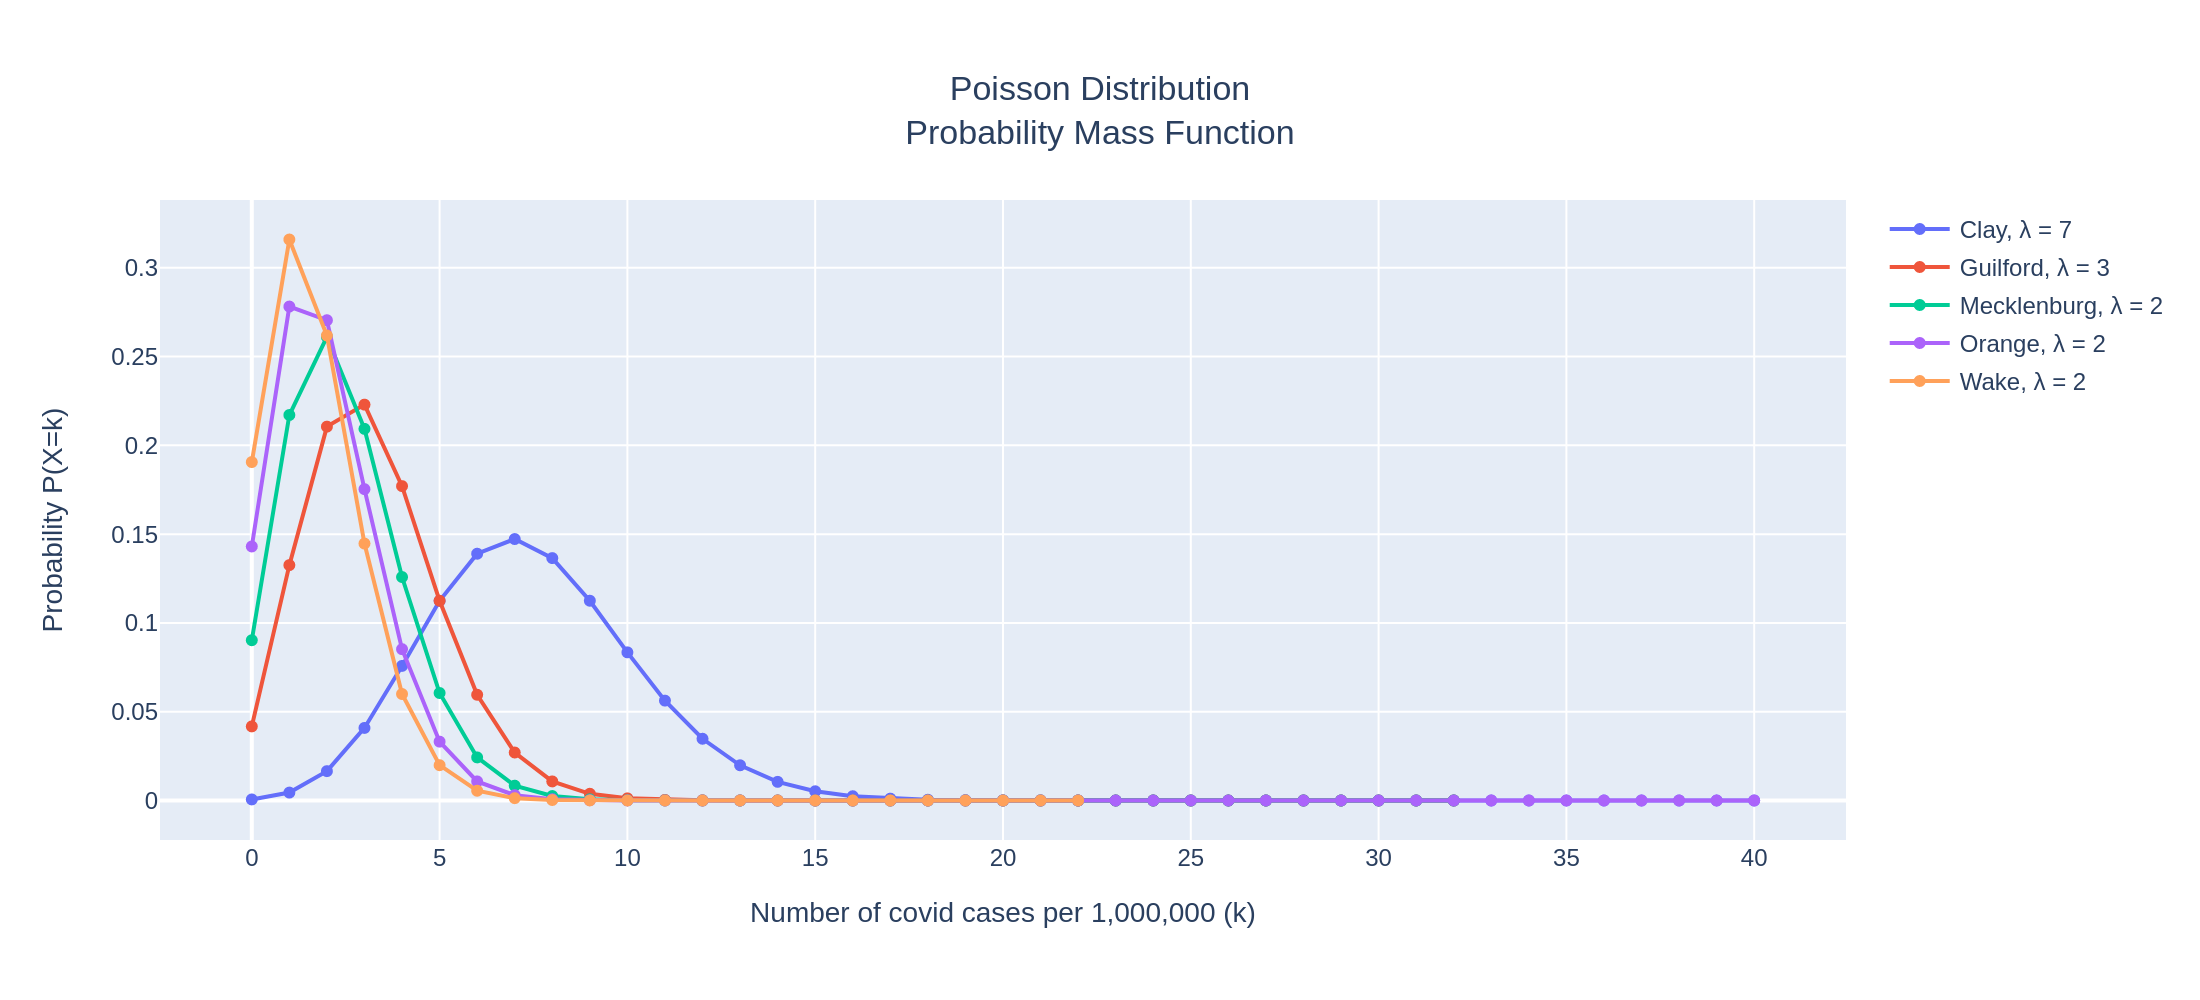

In [49]:
fig = go.Figure()
nc_data = super_dataset[(super_dataset.State == "NC") & (super_dataset.population != 0)]
counties = [37043, 37081, 37119, 37135, 37183]
for i in counties:
    df, poiss, fig = get_poisson_county(nc_data, i, fig, of='deaths', per=1000000, trunc_val=40)
fig.update_layout(
    title="Poisson Distribution<br>Probability Mass Function",
    title_x=0.5,
    xaxis_title="Number of covid cases per 1,000,000 (k)",
    yaxis_title="Probability P(X=k)",
    height=500,
)
# fig.show()
img_bytes = fig.to_image(format="png", width=1100, height=500, scale=2)
Image(img_bytes)

<div class="alert-success">
    <h2 style="text-align:center;"><br/><strong>Perform corelation between Enrichment data variables and COVID-19 cases</strong><br/><br/></h2>
</div>

### Load Enrichment dataset and merge with dataset of North Carolina

In [50]:
dp5 = pd.read_csv("../../../../data/stage_I/Census_Demographics_ACS/ACSDP5Y2019.DP05_data_with_overlays_2021-02-11T145452.csv", delimiter=",", dtype=object)
dp5['countyFIPS'] = dp5[1:]['GEO_ID'].apply(lambda x: int(x[-5:]))
dp5['countyFIPS'].fillna(0, inplace=True)
dp5.drop(['GEO_ID'], axis = 1, inplace=True)
dp5 = dp5.astype({'countyFIPS': 'int32'})
dp5 = dp5[[dp5.columns[-1]] + list(dp5.columns[:-1])]
dp5.drop(0, inplace=True)
for i in dp5[dp5.columns[2:]]:
    dp5[i] = pd.to_numeric(dp5[i], errors="coerce")
dp5.dropna(axis='columns', how='any', inplace=True)
dp5.head(2)

,countyFIPS,NAME,DP05_0001E,DP05_0001PE,DP05_0002E,DP05_0002PE,DP05_0003E,DP05_0003PE,DP05_0004E,DP05_0005E,...,DP05_0087M,DP05_0087PE,DP05_0088E,DP05_0088M,DP05_0088PE,DP05_0088PM,DP05_0089E,DP05_0089M,DP05_0089PE,DP05_0089PM
1,1001,"Autauga County, Alabama",55380,55380,26934,48.6,28446,51.4,94.7,3217,...,224,41647,19823,189,47.6,0.2,21824,97,52.4,0.2
2,1003,"Baldwin County, Alabama",212830,212830,103496,48.6,109334,51.4,94.7,11689,...,640,162883,77958,410,47.9,0.2,84925,403,52.1,0.2


In [51]:
nc_data = super_dataset.loc[(super_dataset.State == "NC") & (super_dataset.population != 0)]
days = len([i for i in nc_data.columns if "cases" in i])
nc_data = nc_data.drop(nc_data.columns[5:-2], axis=1)
nc_data.columns = list(nc_data.columns[:-2]) + ['cases', 'deaths']
nc_data.drop(['State', 'StateFIPS', 'deaths'], axis=1, inplace=True)
nc_data.cases = nc_data.cases.apply(lambda x: (x/days))
nc_data = nc_data.merge(dp5, on='countyFIPS')
nc_data.drop('NAME', axis=1, inplace=True)
nc_data.iloc[:, 3:] = nc_data.iloc[:, 2:].apply(lambda x: round(x/x[0]*100000), axis=1).astype('int').iloc[:,1:]
nc_data.head()

,countyFIPS,County Name,population,cases,DP05_0001E,DP05_0001PE,DP05_0002E,DP05_0002PE,DP05_0003E,DP05_0003PE,...,DP05_0087M,DP05_0087PE,DP05_0088E,DP05_0088M,DP05_0088PE,DP05_0088PM,DP05_0089E,DP05_0089M,DP05_0089PE,DP05_0089PM
0,37001,Alamance County,169509,23,96351,96351,45745,28,50606,31,...,374,69959,32115,225,27,0,37845,232,32,0
1,37003,Alexander County,37497,25,99243,99243,50511,136,48732,131,...,525,77172,39747,448,137,1,37424,400,129,1
2,37005,Alleghany County,11137,20,98842,98842,48523,441,50319,457,...,754,78262,37928,664,435,5,40334,584,462,5
3,37007,Anson County,24446,23,101865,101865,53408,214,48458,195,...,687,80496,42215,777,214,2,38280,307,195,2
4,37009,Ashe County,27203,17,98750,98750,48550,181,50200,187,...,485,78723,37944,375,177,1,40779,357,190,1


In [52]:
meta_data = pd.read_csv("../../../../data/stage_I/Census_Demographics_ACS/ACSDP5Y2019.DP05_metadata_2021-02-11T145452.csv", delimiter=",", dtype=object)
meta_data.index = meta_data.GEO_ID

In [53]:
cols = ['DP05_0011E', 'DP05_0086E', 'DP05_0088E']
for i in cols:
    corr = nc_data.cases.corr(nc_data[i])
    print(corr, meta_data.loc[i].id)

0.282717750006733 Estimate!!SEX AND AGE!!Total population!!35 to 44 years
-0.24382534376614082 Estimate!!Total housing units
-0.03062896245217775 Estimate!!CITIZEN, VOTING AGE POPULATION!!Citizen, 18 and over population!!Male


<br/>

From the result above, we can say that there is a **positive correlation** between total population between 35 to 44 years and the number of covid cases.
Similarly, there is a **negative correlation** between housing units and number of covid cases and **no correlation** between number of people eligible for voting and the number of covid cases.

<div class="alert-success">
    <h2 style="text-align:center;"><br/><strong>Formulate hypothesis between Enrichment data and number of cases</strong><br/><br/></h2>
</div>

We saw the correlation above. From that observation we can formulate the following hypothesis:

1. Higher number of population between 35 and 44 years of age have contributed in increment of daily covid cases.
2. Higher number of people eligible for voting has no effect on the increment or decrement of daily covid cases.
3. If we have increase in housing units, it contributes in decreasing the number of daily covid cases.